In [95]:
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from pandas.tseries.offsets import DateOffset 
from sklearn.preprocessing import MinMaxScaler
from lineartree import LinearTreeRegressor
from joblib import dump, load
import requests
import xmltodict
import joblib
# warnings.filterwarnings('ignore')

# Loading functions

In [16]:
def bdf_request(dataset, id_list):
    token = "8c405577-925f-4f96-9a89-df95aceb3e61"
    url = f"https://api.webstat.banque-france.fr/webstat-fr/v1/data/{dataset}/"
    
    for id in id_list:
        url = url + id + "+"

    headers = {
    "X-IBM-Client-Id": token,
    "accept": "application/json"
    }

    params = {
    # "startPeriod": "2020-Q1",
    # "endPeriod": "2020-Q2"
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    return data

def parse_bdf_request(data):
    df = pd.DataFrame(columns=['Date'])
    for serie in data['seriesObs']:
        sub_df = pd.DataFrame()
        dates = []
        values = []
        for obs in serie['ObservationsSerie']['observations']:
            dates.append(obs['ObservationPeriod']['periodFirstDate'])
            values.append(pd.to_numeric(obs['ObservationPeriod']['value']))
        sub_df['Date'] = dates
        sub_df[serie['ObservationsSerie']['title']] = values
        df = df.merge(sub_df, on='Date', how='outer')

    if serie['ObservationsSerie']['frequency'] == 'A':
        df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y %H:%M:%S") + pd.offsets.MonthEnd(12)
    elif serie['ObservationsSerie']['frequency'] == 'Q':
        df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y %H:%M:%S") + pd.offsets.MonthEnd(3)  
    elif serie['ObservationsSerie']['frequency'] == 'M':
        df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y %H:%M:%S") + pd.offsets.MonthEnd(1) 
    
    return df

In [17]:
quarterly_bdf_ids_1 = [
    'CFT.Q.N.FR.W0.S1M.S1.N.A.LE.F62A._Z._Z.XDC._T.S.V.N._T',
    'CFT.Q.N.FR.W0.S1M.S1.N.A.LE.F62B._Z._Z.XDC._T.S.V.N._T'
]

quarterly_bdf_ids_2 = [
    'CNF.Q.N.FR.W0.S1M.S1.N.A.LE.F2.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.L.F.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.L.F.F4.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F4.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F3.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F5._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.L.F.F5._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.F.F3.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.F.F3.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.F.F5._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.F.F51._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.LE.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.LE.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.F.F6._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.F.F6._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.LE.F521._Z._Z.XDC._T.S.V.N._T'
]

monthly_bdf_ids_1 = [
    'BSI1.M.FR.N.A.L21.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L22.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L22FRPL.A.1.U6.2251.Z01.E',
    'BSI1.M.FR.N.A.L23.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L23FRLA.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L23FRLD.A.1.U6.2251.Z01.E',
    'BSI1.M.FR.N.R.A220Z.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.R.A210Z.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.R.A2N1Z.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.N.R.A2N2Z.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.N.F.L30.A.8.Z5.0000.Z01.T',
    'BSI1.M.FR.N.A.L22.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.N.A.L21.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.Y.R.A220Z.A.4.U6.2254FR.Z01.E',
    'BSI1.M.FR.N.R.A220Z.A.4.U6.2254FR.Z01.E'
]

monthly_bdf_ids_2 = [
    'MIR1.M.FR.B.A22.A.5.A.2254U6.EUR.N',
    'MIR1.M.FR.B.A2B.A.5.A.2250U6.EUR.N',
    'MIR1.M.FR.B.A22HR.A.5.A.2254U6.EUR.N'
    
]

monthly_bdf_ids_3 = [
    'MIR.M.FR.B.L22.H.R.A.2240.EUR.N'
]

data_bdf_quarterly_1 = bdf_request('CFT', quarterly_bdf_ids_1)
df_bdf_quarterly_1 = parse_bdf_request(data_bdf_quarterly_1)

data_bdf_quarterly_2 = bdf_request('CNF', quarterly_bdf_ids_2)
df_bdf_quarterly_2 = parse_bdf_request(data_bdf_quarterly_2)

df_bdf_quarterly = df_bdf_quarterly_1.merge(df_bdf_quarterly_2, on='Date', how='outer')
df_bdf_quarterly = df_bdf_quarterly.sort_values('Date', ascending=False)
for col in df_bdf_quarterly.columns:
    if col != 'Date':
        df_bdf_quarterly[col] = df_bdf_quarterly[col] * 1e3
display(df_bdf_quarterly.head())

data_bdf_monthly_1 = bdf_request('BSI1', monthly_bdf_ids_1)
df_bdf_monthly_1 = parse_bdf_request(data_bdf_monthly_1)

data_bdf_monthly_2 = bdf_request('MIR1', monthly_bdf_ids_2)
df_bdf_monthly_2 = parse_bdf_request(data_bdf_monthly_2)
for col in df_bdf_monthly_2.columns:
    if col != 'Date':
        df_bdf_monthly_2[col] = df_bdf_monthly_2[col] * 1e3

data_bdf_monthly_3 = bdf_request('MIR', monthly_bdf_ids_3)
df_bdf_monthly_3 = parse_bdf_request(data_bdf_monthly_3)

df_bdf_monthly = df_bdf_monthly_1.merge(df_bdf_monthly_2, on='Date', how='outer').merge(df_bdf_monthly_3, on='Date', how='outer')
df_bdf_monthly = df_bdf_monthly.sort_values('Date', ascending=False)
df_bdf_monthly[["Titres d'OPC monétaires, taux de valorisation de l'encours", "Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"]] = df_bdf_monthly[["Titres d'OPC monétaires, taux de valorisation de l'encours", "Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"]] / 100
display(df_bdf_monthly.head())


,Date,"Assurance-vie en unités de compte, actif des ménages, encours trimestriel","Assurance-vie support euro, actif des ménages, encours trimestriel",Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - encours de monnaie et dépôts,Passif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux des autres comptes à recevoir ou à payer,Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux des autres comptes à recevoir ou à payer,Passif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux de crédits,Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux de crédits,Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux de titres de créances,Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux d'actions et titres d'OPC,Passif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux d'actions et titres d'OPC,Passif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux de titres de créances,Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux de titres de créances,Passif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux d'actions et titres d'OPC,Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux d'actions et titres d'OPC,Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours des autres comptes à recevoir ou à payer,Passif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours des autres comptes à recevoir ou à payer,Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux de police d'assurance et fonds de pension,Passif des SNF vis-à-vis de toutes contreparties - flux de police d'assurance et fonds de pension,Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours d'OPC monétaires
109,2023-03-31,461100.0,1478616.0,2.047179e+09,18726000.0,17222000.0,7867000.0,-3000.0,577000.0,1772000.0,0.0,-3267000.0,2083000.0,16212000.0,-6011000.0,1.500713e+09,1.107175e+09,3677000.0,0.0,85731000.0
108,2022-12-31,436600.0,1470513.0,2.024920e+09,-42620000.0,-24139000.0,15434000.0,-1020000.0,1438000.0,5398000.0,0.0,-324000.0,-829000.0,35239000.0,26215000.0,1.492854e+09,1.103210e+09,-1920000.0,0.0,67318000.0
107,2022-09-30,440699.0,1435961.0,2.024519e+09,39768000.0,9200000.0,22692000.0,-138000.0,1287000.0,2036000.0,0.0,-2362000.0,1246000.0,19926000.0,12839000.0,1.473395e+09,1.102579e+09,-165000.0,0.0,56141000.0
106,2022-06-30,447700.0,1492839.0,1.993505e+09,-13407000.0,10234000.0,29423000.0,769000.0,1188000.0,22090000.0,0.0,-4197000.0,7322000.0,28631000.0,13156000.0,1.413530e+09,1.089912e+09,-1124000.0,0.0,52857000.0
105,2022-03-31,473199.0,1598667.0,1.965109e+09,29916000.0,35607000.0,16291000.0,493000.0,103000.0,1230000.0,0.0,713000.0,3098000.0,30750000.0,55542000.0,1.390130e+09,1.065095e+09,2588000.0,0.0,55903000.0


,Date,"Dépôts à vue des ménages et ISBLSM résidents, encours","Dépôts à terme des ménages et ISBLSM résidents, encours","PEL des ménages résidents, encours","Livrets d'épargne des ménages et ISBLSM résidents, encours","Livrets A des ménages et ISBLSM résidents, encours","Livrets de développement durable et solidaire des ménages résidents, encours","Crédits à l'habitat accordés aux ménages et ISBLSM résidents, encours","Crédits à la consommation accordés aux ménages et ISBLSM résidents, encours","Crédits à l'investissement accordés aux sociétés non financières résidentes, encours","Crédits de trésorerie accordés aux sociétés non financières résidentes, encours","Titres d'OPC monétaires, taux de valorisation de l'encours","Dépôts à terme des SNF résidentes, encours","Dépôts à vue des SNF résidentes, encours","Crédits à l'habitat accordés aux particuliers résidents, flux mensuels, CVS","Crédits à l'habitat accordés aux particuliers résidents, flux mensuels","Crédits nouveaux à l'habitat des particuliers, flux CVS","Crédits nouveaux à la consommation des ménages - hors découverts, flux CVS","Crédits nouveaux à l'habitat (hors renégociations) aux particuliers résidents, flux, CVS","Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"
365,2023-08-31,602165.0,407089.0,260856.0,881965.0,360591.0,144272.0,1431864.0,219255.0,949178.0,313257.0,NaN,242162.0,537258.0,698.0,-1125.0,11700.0,6000.0,9900.0,0.038555
364,2023-07-31,610639.0,403900.0,262634.0,878081.0,358158.0,143535.0,1432978.0,220007.0,948089.0,326059.0,0.02039,242928.0,544442.0,388.0,2450.0,12000.0,5900.0,10100.0,0.038616
363,2023-06-30,609965.0,397420.0,264820.0,874424.0,355054.0,142557.0,1430095.0,219815.0,942294.0,322541.0,0.01704,234122.0,553853.0,1011.0,3744.0,12900.0,6000.0,11100.0,0.033022
362,2023-05-31,607170.0,393533.0,268087.0,874112.0,352624.0,141735.0,1425849.0,219302.0,937767.0,326567.0,0.01389,226428.0,556364.0,1698.0,1635.0,14000.0,5800.0,12000.0,0.034094
361,2023-04-30,614929.0,389999.0,270463.0,872258.0,349540.0,140685.0,1424177.0,217721.0,928596.0,337031.0,0.01037,227817.0,565844.0,2198.0,810.0,14900.0,5900.0,12500.0,0.033128


In [9]:
def insee_request(id_list):
    token = "fd13b343-b9d7-385d-9ae3-a3e53b5a0440"
    url = "https://bdm.insee.fr/series/sdmx/data/SERIES_BDM/"
    
    for id in id_list:
        url = url + id + "+"

    headers = {
    "Authorization": f"Bearer {token}"
    }

    params = {
    # "startPeriod": "2020-Q1",
    # "endPeriod": "2020-Q2"
    }

    response = requests.get(url, headers=headers, params=params)
    data = xmltodict.parse(response.content)
    return data

    

def parse_insee_request(data):
    df = pd.DataFrame(columns=['Date'])

    if type(data['message:StructureSpecificData']['message:DataSet']['Series']) == list:
        series = data['message:StructureSpecificData']['message:DataSet']['Series']
    else:
        series = [data['message:StructureSpecificData']['message:DataSet']['Series']]

    for serie in series:
        sub_df = pd.DataFrame()
        unit_mult = 10**float(serie['@UNIT_MULT'])
        dates = []
        values = []
        for obs in serie['Obs']:
            dates.append(obs['@TIME_PERIOD'])
            values.append(float(obs['@OBS_VALUE']) * unit_mult)
        sub_df['Date'] = dates
        
        sub_df[serie['@TITLE_FR']] = values
        df = df.merge(sub_df, on='Date', how='outer')

    if serie['@FREQ'] == 'A':
        df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(12)
    elif serie['@FREQ'] == 'T':
        df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(3)  
    elif serie['@FREQ'] == 'M':
        df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(1)  
    
    return df
    

In [10]:
annual_insee_ids = [
    '010564058',
    '010563884'
    # '010563893',
]

quarterly_insee_ids = [
    '010564925', #RDB courant
    '010565711', #Conso ménages courant
    '010565712', #Conso ménages constant
    '010564934', #Epargne ménages courant,
    '010565738', #FBCF courant ménages
    '010565734', #FBCF constant ménages
    '010565724', #Exportation courant
    '010565725', #Exportation constant
    '010565726', #Import courant
    '010565727', #Import constant
    '010565717', #Conso totale courant
    '010565718', #Conso totale constant
    '010564879', #Menages aide à l'investissement,
    '010564890',
    '010564889',
    '010564874',
    '010564983',
    '010564909',
    '010564694',
    '010564707',
    '010564734',
    '010564744',
    '010564755',
    '010564767',
    '010564766',
    '010564789',
    '010564848',
    '010564866',
    '010564865',
    '010564833',
    '010564840',
    '010564880',
    '010564892',
    '010564891',
    '010564975',
    '010564898',
    '010565707',
    '010565708',
    '010565730',
    '010565731',
    '010564901',
    '010564931',
    '010564875',
    '010564883',
    '010564884',
    '010564871',
    '010565536',
    '010565746',
    '010565745'
]

monthly_insee_ids = [
   '001769682' #CPI
]

data_insee_annual = insee_request(annual_insee_ids)
df_insee_annual = parse_insee_request(data_insee_annual)
display(df_insee_annual.head())

data_insee_quarterly = insee_request(quarterly_insee_ids)
df_insee_quarterly = parse_insee_request(data_insee_quarterly)
display(df_insee_quarterly.head())

data_insee_monthly = insee_request(monthly_insee_ids)
df_insee_monthly = parse_insee_request(data_insee_monthly)
display(df_insee_monthly.head())

,Date,Comptes nationaux annuels base 2014 - Acquisitions moins cessions d'actifs non financiers non produits - Sociétés non financières - Emplois ou actifs,Comptes nationaux annuels base 2014 - Variation de stocks - Ménages y compris EI - Emplois ou Actifs
0,2021-12-31,NaN,1.534000e+09
1,2020-12-31,522000000.0,1.534000e+09
2,2019-12-31,524000000.0,8.610000e+08
3,2018-12-31,97000000.0,1.833000e+09
4,2017-12-31,465000000.0,8.480000e+08


,Date,Dépenses de consommation totales - Valeur aux prix courants - Série CVS-CJO,Exportations - Total - Valeur aux prix courants - Série CVS-CJO,Prestations d'assistance sociale en espèces versées par les ISBLSM - Valeur aux prix courants - Série CVS,Investissement des entreprises non financières - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO,Variations de stocks des sociétés non financières - Valeur aux prix courants - Série CVS-CJO,Acquisitions nettes d'actifs non produits versées par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS,Épargne des sociétés non financières - Valeur aux prix courants - Série CVS-CJO,Autres subventions sur la production reçues par les ISBLSM - Valeur aux prix courants - Série CVS,Dépenses de consommation des ménages - Total - Valeur aux prix courants - Série CVS-CJO,...,Aides à l'investissement reçues par les sociétés non financières - Valeur aux prix courants - Série CVS,FBCF des ménages - Total - Valeur aux prix courants - Série CVS-CJO,Revenus de la propriété attribués aux assurés reçus par les ISBLSM - Valeur aux prix courants - Série CVS,Dépenses de consommation des ménages - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO,Produit intérieur brut total - Valeur aux prix courants - Série CVS-CJO,Formation brute de capital fixe des ISBLSM - Valeur aux prix courants - Série CVS-CJO,Autres transferts en capital reçus par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS,Intérêts versés par les ISBLSM - Valeur aux prix courants - Série CVS,Autres transferts en capital à payer par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS,Indemnités d'assurance-dommage reçues par les ISBLSM - Valeur aux prix courants - Série CVS
0,2023-06-30,5.336830e+11,2.317640e+11,123000000.0,8.557900e+10,5.752000e+09,-937000000.0,8.487100e+10,-106000000.0,3.566360e+11,...,6.410000e+09,4.011100e+10,42000000.0,3.013270e+11,7.016160e+11,1.456000e+09,336000000.0,143000000.0,-718000000.0,19000000.0
1,2023-03-31,5.295700e+11,2.300780e+11,122000000.0,8.512600e+10,2.031000e+09,-932000000.0,7.706200e+10,-114000000.0,3.535950e+11,...,6.431000e+09,4.034000e+10,40000000.0,3.028770e+11,6.853460e+11,1.438000e+09,342000000.0,118000000.0,-718000000.0,19000000.0
2,2022-12-31,5.218730e+11,2.344060e+11,121000000.0,8.514000e+10,4.658000e+09,-924000000.0,7.806700e+10,-127000000.0,3.461740e+11,...,6.457000e+09,4.030500e+10,38000000.0,3.025040e+11,6.732340e+11,1.421000e+09,351000000.0,75000000.0,-721000000.0,19000000.0
3,2022-09-30,5.156020e+11,2.373830e+11,121000000.0,8.455600e+10,1.053300e+10,-926000000.0,8.079200e+10,-133000000.0,3.419250e+11,...,6.462000e+09,4.024300e+10,37000000.0,3.040690e+11,6.657590e+11,1.401000e+09,348000000.0,44000000.0,-711000000.0,19000000.0
4,2022-06-30,5.060940e+11,2.258520e+11,120000000.0,8.111400e+10,8.194000e+09,-938000000.0,7.451700e+10,-132000000.0,3.356220e+11,...,6.445000e+09,3.990500e+10,35000000.0,3.035370e+11,6.542020e+11,1.367000e+09,334000000.0,23000000.0,-688000000.0,19000000.0


,Date,Indice CVS des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble
0,2023-08-31,118.20
1,2023-07-31,117.30
2,2023-06-30,117.30
3,2023-05-31,117.26
4,2023-04-30,117.47


# I. SNF

In [163]:
train_range = ('2003-03-01', '2022-08-01')

## 1. Arbitrage

In [164]:
df_scenario = pd.read_excel('20230915 - RUN/Envoi_Data_Scenario_France_Central_APR_20230918.xlsx')
df_scenario['Date'] = pd.to_datetime(df_scenario['Date'])
df_scenario.head()

,Unnamed: 0,Date,OAT_10Y,EUSW10V3,GDP_courant,GDP_constant,Euribor_3M,CPI,Inflation,CAC40,LA_rate,RDB_constant,RDB_constant (monthly transformed),RDB_courant,RDB_courant (monthly transformed),taux_chomage,"GDP / current prices, % ch yoy / quarterly","GDP / constant prices, % ch yoy / quarterly","Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly","Household consumption / constant prices, % ch yoy / quarterly","Public consumption / constant prices, % ch yoy / quarterly","Investment, private, households / constant prices, % ch yoy / quarterly","Imports of goods and services / constant prices, % ch yoy / quarterly","Exports of goods and services / constant prices, % ch yoy / quarterly",CPI index / % ch yoy / quarterly,"Investment, private, NFC / constant prices, % ch yoy / quarterly","Non financial companies' saving ratio / constant prices, % of value added / quarterly","Non financial companies' profit ratio / constant prices, % of value added / quarterly"
0,0,2000-01-31,5.667,5.9090,120586.469136,149927.037037,3.34314,77.4,1.54,5661.53,2.25,0.0,0.0,0.0,71971.395062,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2000-02-29,5.626,5.9210,120783.617284,150098.259259,3.53675,77.5,1.36,6121.95,2.25,0.0,0.0,0.0,72106.098765,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,2000-03-31,5.452,5.7735,121157.604938,150428.345679,3.74704,77.9,1.49,6374.75,2.25,0.0,0.0,216466.0,72376.382716,8.7,5.243168,4.357053,2.961124,4.776229,2.050529,5.579869,13.37296,12.360544,1.570133,6.888763,21.754064,32.367585
3,3,2000-04-30,5.356,5.7127,122064.148148,151213.679012,3.92904,77.9,1.21,6228.65,2.25,0.0,0.0,0.0,73008.197531,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,2000-05-31,5.501,5.9057,122665.259259,151695.975309,4.35038,78.1,1.40,6346.45,2.25,0.0,0.0,0.0,73363.271605,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


In [165]:
""" Unique processing """
df_scenario['RDB_constant'] = df_scenario['RDB_constant (monthly transformed)']
df_scenario['RDB_courant'] = df_scenario['RDB_courant (monthly transformed)']
df_scenario["GDP / current prices, % ch yoy / quarterly"] = df_scenario["GDP / current prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["GDP / constant prices, % ch yoy / quarterly"] = df_scenario["GDP / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly"] = df_scenario["Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Household consumption / constant prices, % ch yoy / quarterly"] = df_scenario["Household consumption / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Public consumption / constant prices, % ch yoy / quarterly"] = df_scenario["Public consumption / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Investment, private, households / constant prices, % ch yoy / quarterly"] = df_scenario["Investment, private, households / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Imports of goods and services / constant prices, % ch yoy / quarterly"] = df_scenario["Imports of goods and services / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Exports of goods and services / constant prices, % ch yoy / quarterly"] = df_scenario["Exports of goods and services / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["CPI index / % ch yoy / quarterly"] = df_scenario["CPI index / % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Investment, private, NFC / constant prices, % ch yoy / quarterly"] = df_scenario["Investment, private, NFC / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Non financial companies' saving ratio / constant prices, % of value added / quarterly"] = df_scenario["Non financial companies' saving ratio / constant prices, % of value added / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Non financial companies' profit ratio / constant prices, % of value added / quarterly"] = df_scenario["Non financial companies' profit ratio / constant prices, % of value added / quarterly"].replace(0, np.nan).bfill() / 100

pd.options.display.max_columns = None
df_scenario.head()

,Unnamed: 0,Date,OAT_10Y,EUSW10V3,GDP_courant,GDP_constant,Euribor_3M,CPI,Inflation,CAC40,LA_rate,RDB_constant,RDB_constant (monthly transformed),RDB_courant,RDB_courant (monthly transformed),taux_chomage,"GDP / current prices, % ch yoy / quarterly","GDP / constant prices, % ch yoy / quarterly","Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly","Household consumption / constant prices, % ch yoy / quarterly","Public consumption / constant prices, % ch yoy / quarterly","Investment, private, households / constant prices, % ch yoy / quarterly","Imports of goods and services / constant prices, % ch yoy / quarterly","Exports of goods and services / constant prices, % ch yoy / quarterly",CPI index / % ch yoy / quarterly,"Investment, private, NFC / constant prices, % ch yoy / quarterly","Non financial companies' saving ratio / constant prices, % of value added / quarterly","Non financial companies' profit ratio / constant prices, % of value added / quarterly"
0,0,2000-01-31,5.667,5.9090,120586.469136,149927.037037,3.34314,77.4,1.54,5661.53,2.25,0.0,0.0,71971.395062,71971.395062,0.0,0.052432,0.043571,0.029611,0.047762,0.020505,0.055799,0.133730,0.123605,0.015701,0.068888,0.217541,0.323676
1,1,2000-02-29,5.626,5.9210,120783.617284,150098.259259,3.53675,77.5,1.36,6121.95,2.25,0.0,0.0,72106.098765,72106.098765,0.0,0.052432,0.043571,0.029611,0.047762,0.020505,0.055799,0.133730,0.123605,0.015701,0.068888,0.217541,0.323676
2,2,2000-03-31,5.452,5.7735,121157.604938,150428.345679,3.74704,77.9,1.49,6374.75,2.25,0.0,0.0,72376.382716,72376.382716,8.7,0.052432,0.043571,0.029611,0.047762,0.020505,0.055799,0.133730,0.123605,0.015701,0.068888,0.217541,0.323676
3,3,2000-04-30,5.356,5.7127,122064.148148,151213.679012,3.92904,77.9,1.21,6228.65,2.25,0.0,0.0,73008.197531,73008.197531,0.0,0.060883,0.047734,0.033617,0.048541,0.021410,0.045539,0.166557,0.149021,0.015385,0.061023,0.217187,0.328213
4,4,2000-05-31,5.501,5.9057,122665.259259,151695.975309,4.35038,78.1,1.40,6346.45,2.25,0.0,0.0,73363.271605,73363.271605,0.0,0.060883,0.047734,0.033617,0.048541,0.021410,0.045539,0.166557,0.149021,0.015385,0.061023,0.217187,0.328213


In [166]:
df_target = df_bdf_monthly[['Date', 'Dépôts à vue des SNF résidentes, encours', 'Dépôts à terme des SNF résidentes, encours']]
df_target = df_target.merge(df_bdf_quarterly[["Date", "Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours d'OPC monétaires"]], on='Date', how='left')
df_target["Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours d'OPC monétaires"] = df_target["Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours d'OPC monétaires"].bfill() / 1e3

In [167]:
### SNF
model_dav_part_stable_SNF = load(f'models/dav_part_stable_SNF.joblib')
drivers = ['OAT_10Y_diff', 'EUSW10V3_diff', 'Inflation_diff', 'SNF_flux_credit'] + [f"month_{i}" for i in range(3, 13)]

df_dav_SNF_histo = df_bdf_monthly[['Date', "Crédits à l'investissement accordés aux sociétés non financières résidentes, encours", "Crédits de trésorerie accordés aux sociétés non financières résidentes, encours", "Dépôts à vue des SNF résidentes, encours"]]
df_dav_SNF_histo = df_dav_SNF_histo.merge(df_scenario, on='Date', how='left')
df_dav_SNF_histo['SNF_flux_credit'] = df_dav_SNF_histo[["Crédits à l'investissement accordés aux sociétés non financières résidentes, encours", "Crédits de trésorerie accordés aux sociétés non financières résidentes, encours"]].sum(axis=1).diff()
df_dav_SNF_histo['OAT_10Y_diff'] = df_dav_SNF_histo['OAT_10Y'].diff()
df_dav_SNF_histo['EUSW10V3_diff'] = df_dav_SNF_histo['EUSW10V3'].diff()
df_dav_SNF_histo['Inflation_diff'] = df_dav_SNF_histo['Inflation'].diff()
for i in range(1,13):
    df_dav_SNF_histo[f"month_{i}"] = (df_dav_SNF_histo['Date'].dt.month == i).astype(int)
df_dav_SNF_histo = df_dav_SNF_histo[df_dav_SNF_histo['Date'] >= "2013-12"]
df_dav_SNF_histo = df_dav_SNF_histo.sort_values('Date', ascending=True)

df_dav_SNF_histo['dav_part_stable_SNF_diff'] = model_dav_part_stable_SNF.predict(df_dav_SNF_histo[drivers].fillna(0))
dav_part_stable_init =  df_dav_SNF_histo[(df_dav_SNF_histo['Date'].dt.year==2013) & (df_dav_SNF_histo['Date'].dt.month==12)]['Dépôts à vue des SNF résidentes, encours'].values[0] 
df_dav_SNF_histo['dav_part_stable_SNF_histo'] = dav_part_stable_init + (df_dav_SNF_histo['dav_part_stable_SNF_diff'] * (df_dav_SNF_histo['Date'].dt.year > 2013)).cumsum()

df_target = df_target.merge(df_dav_SNF_histo[['Date', 'dav_part_stable_SNF_histo']], on='Date', how='left')


c:\Users\Admin\miniconda3\envs\lfayolle\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [168]:
df_target['SNF_DAV_Vol'] = (df_target['Dépôts à vue des SNF résidentes, encours'] - df_target['dav_part_stable_SNF_histo']).fillna(0.)
df_target['SNF_DAV_Vol'] = df_target['SNF_DAV_Vol'].apply(lambda x: max(x, 0))
df_target['SNF_DAT'] = df_target['Dépôts à terme des SNF résidentes, encours']
df_target['SNF_OPC'] = df_target["Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours d'OPC monétaires"]

df_drivers = df_scenario.copy()

In [169]:
df_scenario.head()

,Unnamed: 0,Date,OAT_10Y,EUSW10V3,GDP_courant,GDP_constant,Euribor_3M,CPI,Inflation,CAC40,LA_rate,RDB_constant,RDB_constant (monthly transformed),RDB_courant,RDB_courant (monthly transformed),taux_chomage,"GDP / current prices, % ch yoy / quarterly","GDP / constant prices, % ch yoy / quarterly","Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly","Household consumption / constant prices, % ch yoy / quarterly","Public consumption / constant prices, % ch yoy / quarterly","Investment, private, households / constant prices, % ch yoy / quarterly","Imports of goods and services / constant prices, % ch yoy / quarterly","Exports of goods and services / constant prices, % ch yoy / quarterly",CPI index / % ch yoy / quarterly,"Investment, private, NFC / constant prices, % ch yoy / quarterly","Non financial companies' saving ratio / constant prices, % of value added / quarterly","Non financial companies' profit ratio / constant prices, % of value added / quarterly"
0,0,2000-01-31,5.667,5.9090,120586.469136,149927.037037,3.34314,77.4,1.54,5661.53,2.25,0.0,0.0,71971.395062,71971.395062,0.0,0.052432,0.043571,0.029611,0.047762,0.020505,0.055799,0.133730,0.123605,0.015701,0.068888,0.217541,0.323676
1,1,2000-02-29,5.626,5.9210,120783.617284,150098.259259,3.53675,77.5,1.36,6121.95,2.25,0.0,0.0,72106.098765,72106.098765,0.0,0.052432,0.043571,0.029611,0.047762,0.020505,0.055799,0.133730,0.123605,0.015701,0.068888,0.217541,0.323676
2,2,2000-03-31,5.452,5.7735,121157.604938,150428.345679,3.74704,77.9,1.49,6374.75,2.25,0.0,0.0,72376.382716,72376.382716,8.7,0.052432,0.043571,0.029611,0.047762,0.020505,0.055799,0.133730,0.123605,0.015701,0.068888,0.217541,0.323676
3,3,2000-04-30,5.356,5.7127,122064.148148,151213.679012,3.92904,77.9,1.21,6228.65,2.25,0.0,0.0,73008.197531,73008.197531,0.0,0.060883,0.047734,0.033617,0.048541,0.021410,0.045539,0.166557,0.149021,0.015385,0.061023,0.217187,0.328213
4,4,2000-05-31,5.501,5.9057,122665.259259,151695.975309,4.35038,78.1,1.40,6346.45,2.25,0.0,0.0,73363.271605,73363.271605,0.0,0.060883,0.047734,0.033617,0.048541,0.021410,0.045539,0.166557,0.149021,0.015385,0.061023,0.217187,0.328213


C:\Users\Admin\AppData\Local\Temp\ipykernel_24388\1243265467.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['total'] = df_train[target_to_drivers.keys()].sum(axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_24388\1243265467.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[k+'_ratio'] = df_train[k]/df_train['total']
C:\Users\Admin\AppData\Local\Temp\ipykernel_24388\1243265467.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

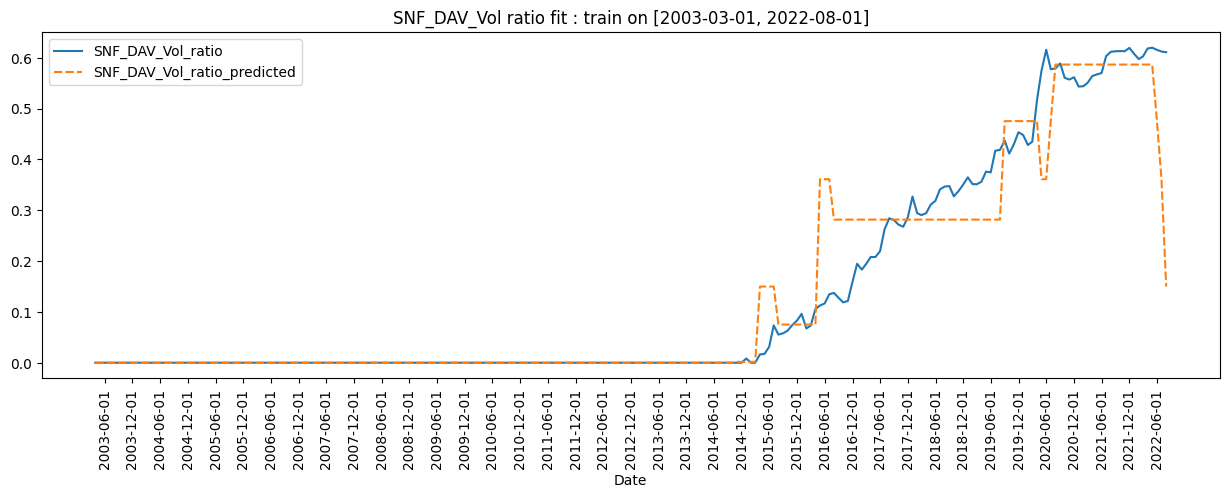

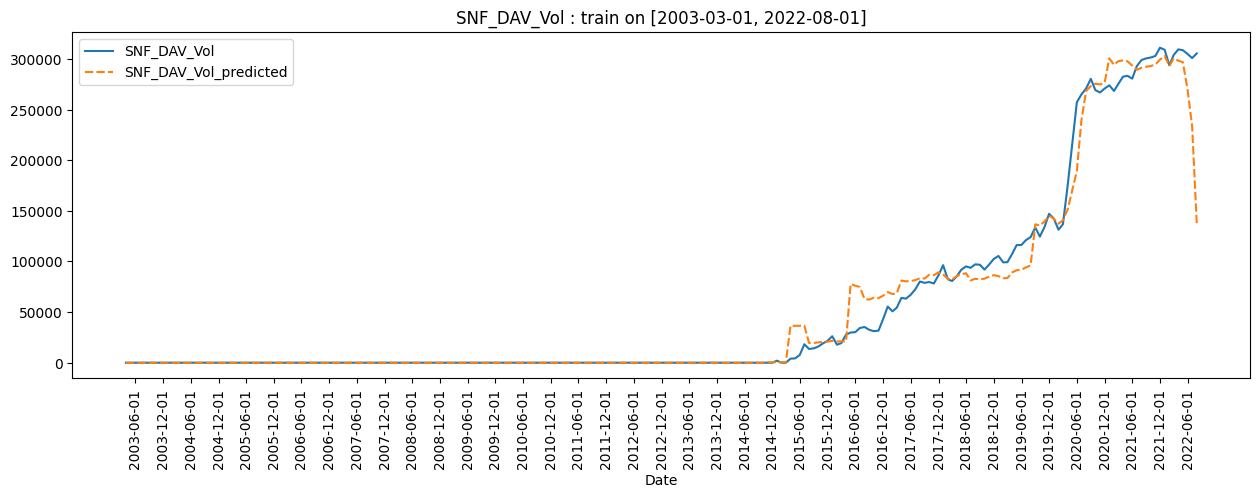

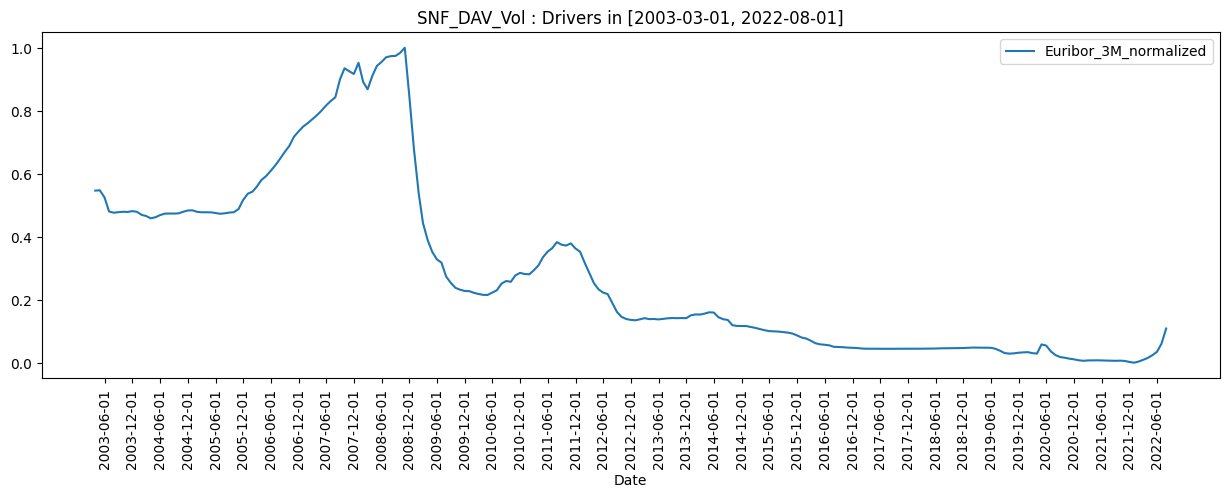

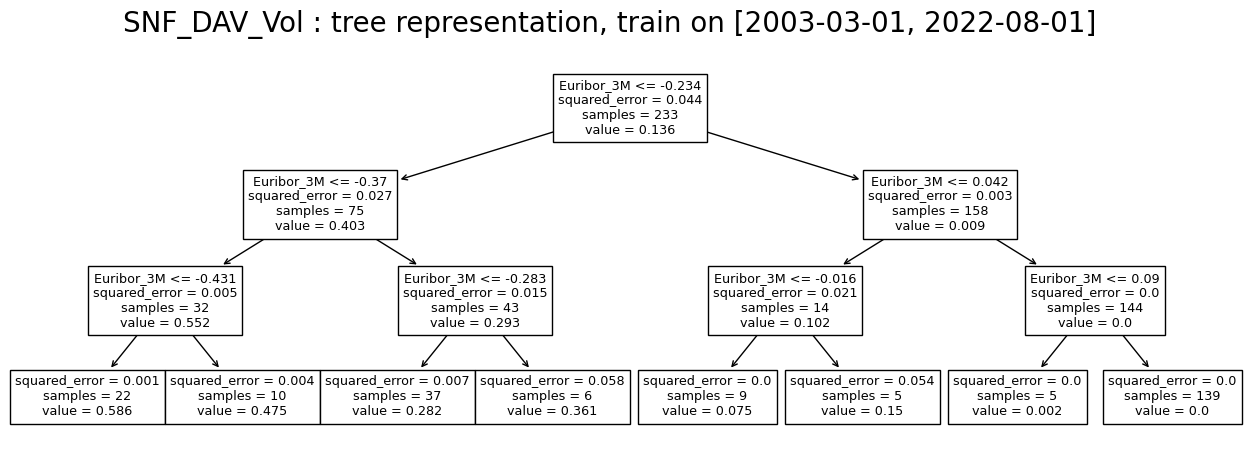

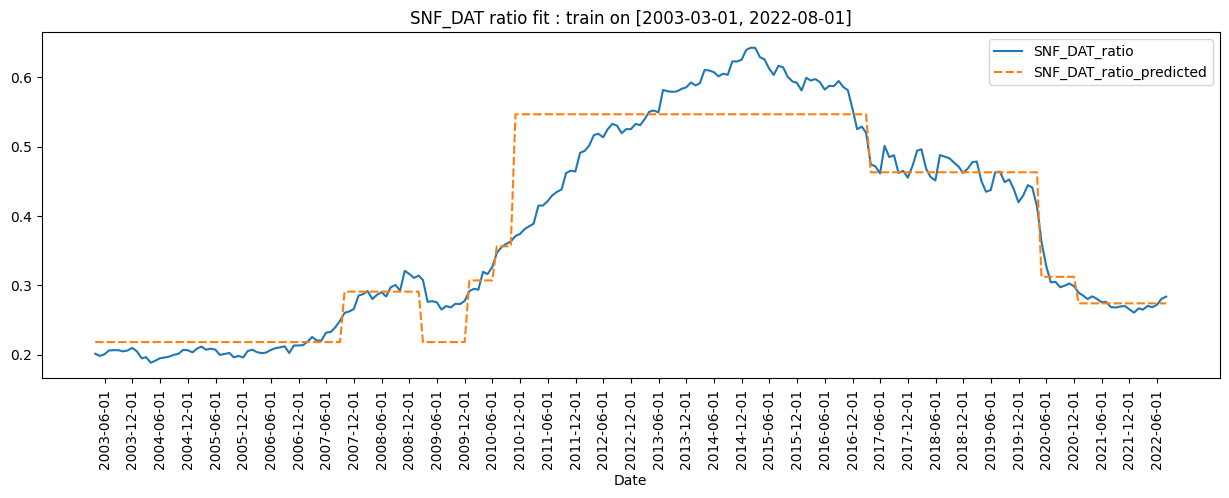

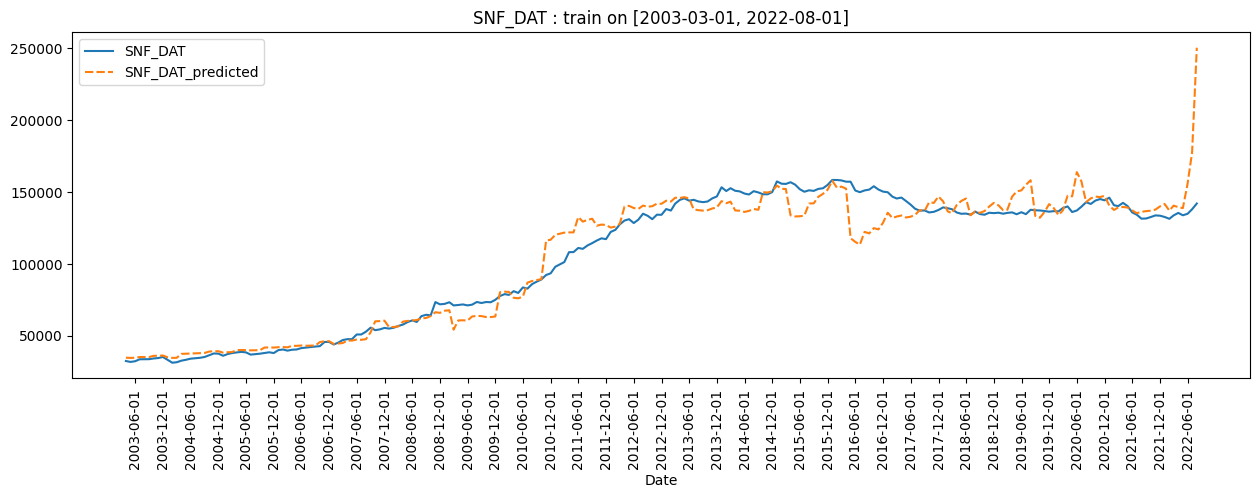

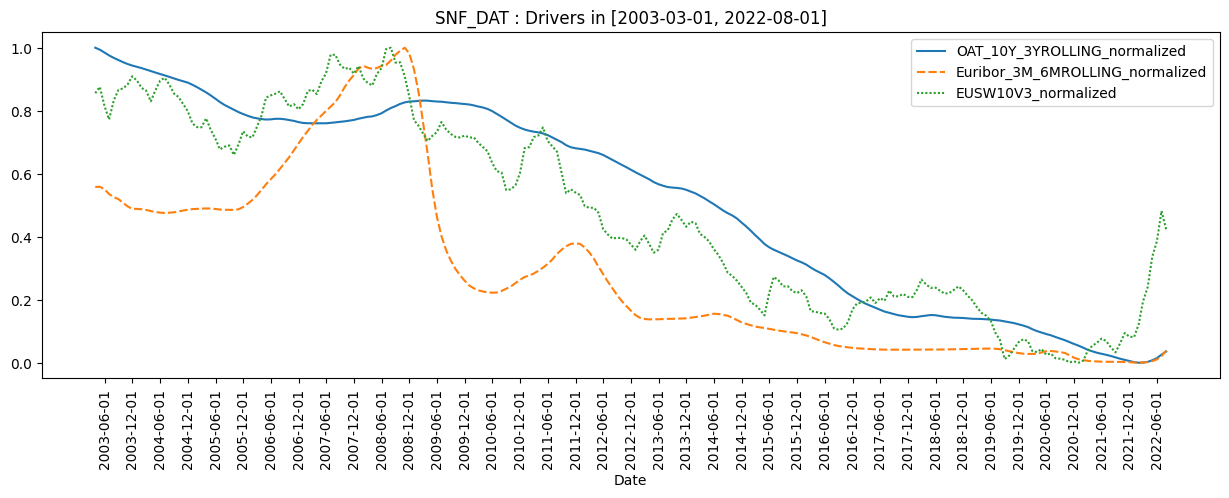

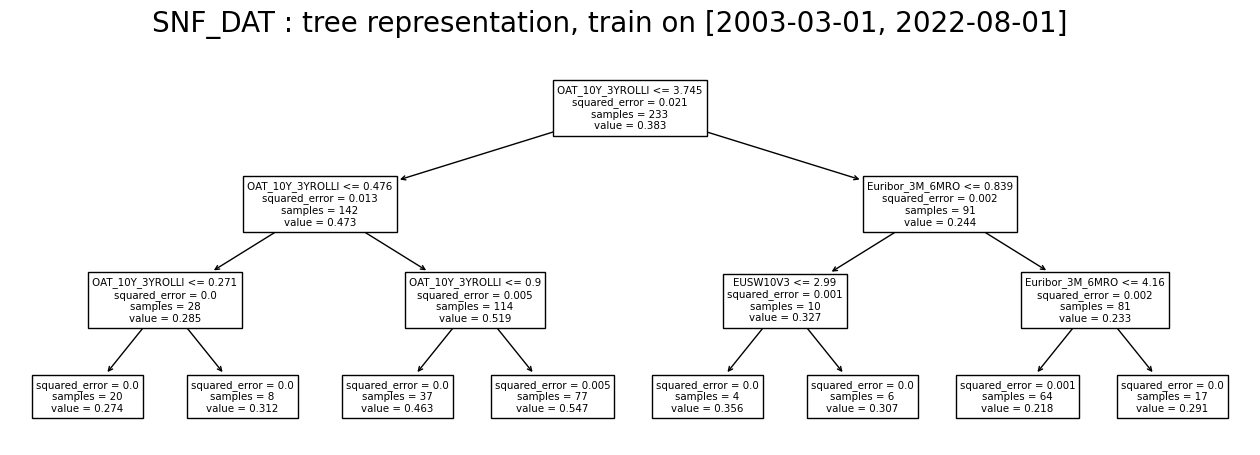

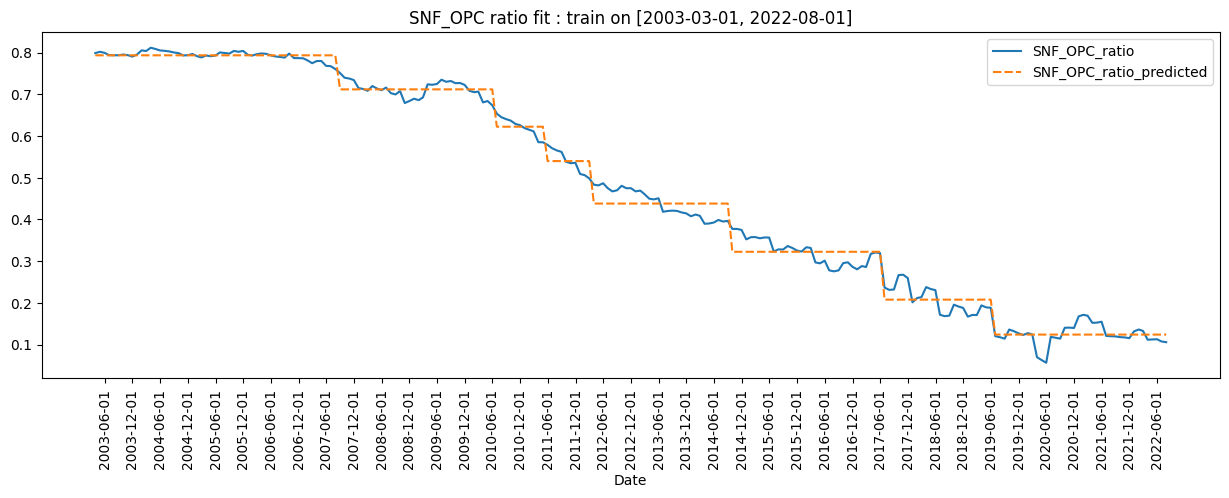

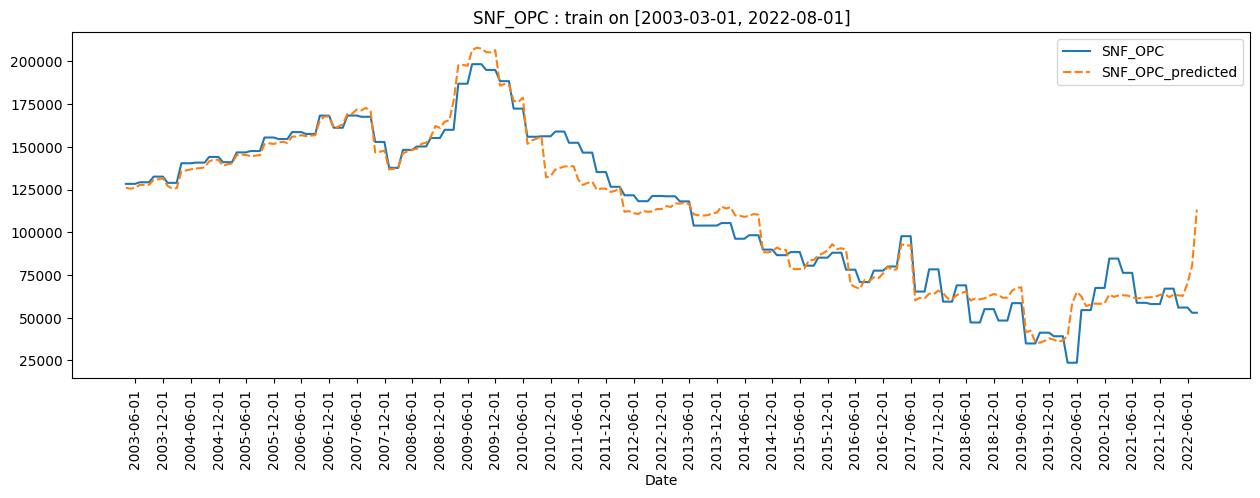

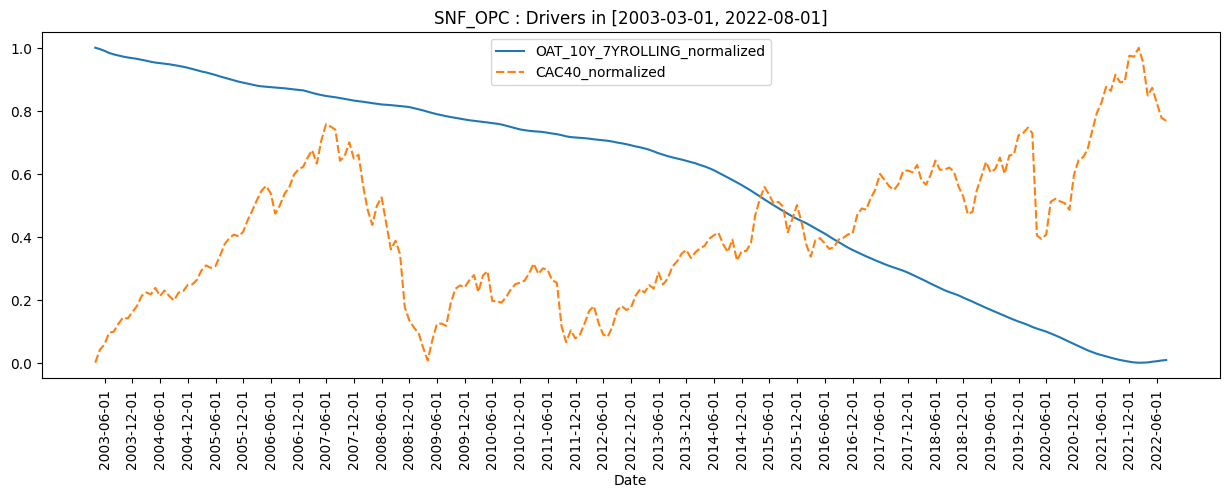

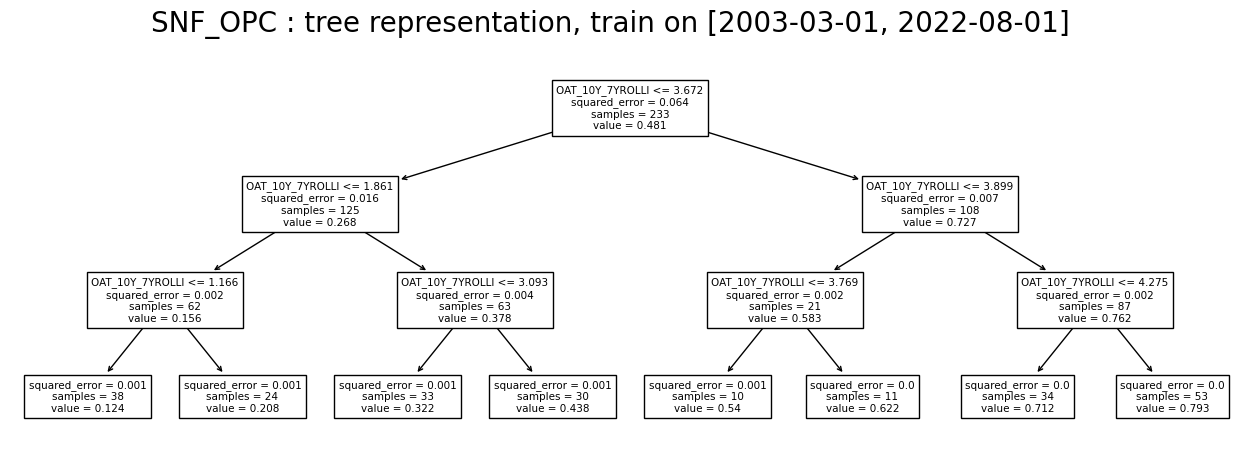

In [171]:
""" Arbitration model fit """

'''LOADING DATA SOURCES'''


# Loading file containing historical drivers used to fit models as well as the drivers used for projection 
df_drivers['Date'] = pd.to_datetime(df_drivers['Date'], format='%YM%m')

# Loading file containing historical targets (here. France deposits) used to fit models

# Building a common dataframe containing drivers and targets
df = df_drivers.merge(df_target, on='Date', how='left').replace('n.a.', np.nan)


'''Feature engineering'''

df['LA_minus_OAT'] = df['LA_rate'] - df['OAT_10Y'].rolling(window=5, min_periods=1).mean()
df['OAT_10Y_3YROLLING'] = df['OAT_10Y'].rolling(window=12*3, min_periods=1).mean()
df['OAT_10Y_7YROLLING'] = df['OAT_10Y'].rolling(window=12*7, min_periods=1).mean()
# df['Menages_DAV_Stable'] = df['Menages_DAV'] - df['Menages_DAV_Vol']
# df['Epargne_menages_ratio'] = df['Epargne_menages_courant'] / df['RDB_courant']


'''Selecting training range and prediction range'''

# Picking historical training range in years/date (bounds included)
# train_range = ('2003-03-01', '2022-09-01')
# backtest_range = ('2022-04-01', '2022-09-01')
# prediction_range = ('2022-06-01', '2027-12-01')


'''Selecting drivers used to make predictions as well as model types'''

target_to_drivers = {
    "SNF_DAV_Vol": ["Euribor_3M"],
    "SNF_DAT": ["OAT_10Y_3YROLLING", "Euribor_3M_6MROLLING"],
    "SNF_OPC": ["OAT_10Y_7YROLLING", "CAC40"]
}
reference = 'Euribor_3M'

models = {
    "SNF_DAV_Vol": DecisionTreeRegressor(max_depth=3, min_samples_leaf=5),
    "SNF_DAT": DecisionTreeRegressor(max_depth=3),
    "SNF_OPC": DecisionTreeRegressor(max_depth=3)
}


'''CALIBRAGE ET PREDICTION'''

df_train = df[(df['Date']<=train_range[1]) & (df['Date']>=train_range[0])]

global_shift = 0
df_train['total'] = df_train[target_to_drivers.keys()].sum(axis=1)
for (k,v) in target_to_drivers.items():
    df_train[k+'_ratio'] = df_train[k]/df_train['total']
    max_shift = 0
    for driver in v:
        if '_shifted_' in driver:
            shift_val = int(driver.split('_')[-1])
            df_train[driver] = df_train['_'.join(driver.split('_')[:-2])].shift(shift_val).fillna(0)
            max_shift = max(max_shift, shift_val)
            global_shift = max(global_shift, shift_val)
        elif '_variation' in driver:
            df_train[driver] = ((df_train['_'.join(driver.split('_')[:-1])] - df_train['_'.join(driver.split('_')[:-1])].shift(1)) / df_train['_'.join(driver.split('_')[:-1])].shift(1)).fillna(0.)
        elif '_referenced' in driver:
            df_train[driver] = (df_train['_'.join(driver.split('_')[:-1])] / df_train[reference]).fillna(0.)
        elif "_6MROLLING" in driver:
            df_train[driver] = df_train['_'.join(driver.split('_')[:-1])].rolling(6, min_periods=1).mean()
    df_train_shift = df_train[df_train['Date']>=df_train['Date'].min()+ DateOffset(months=max_shift)]
    # if k=="SNF_DAV_Vol":
    #     df_train_shift = df_train_shift[df_train_shift['Date']>="2013-04-01"]
    models[k] = models[k].fit(df_train_shift[v], df_train_shift[k+'_ratio'])
    model = models[k]
    df_train[k+'_ratio_predicted'] = model.predict(df_train[v])
    df_train[k+'_ratio_predicted_adjusted'] = df_train[k+'_ratio_predicted'].apply(lambda x: max(x,0))

standardization_factor = df_train[[x+'_ratio_predicted_adjusted' for x in target_to_drivers.keys()]].sum(axis=1)
for (k,v) in target_to_drivers.items():
    df_train[k+'_ratio_predicted_adjusted'] = df_train[k+'_ratio_predicted_adjusted'] / standardization_factor
    df_train[k+'_predicted'] = df_train[k+'_ratio_predicted_adjusted']*df_train['total']

df_plot = df_train.copy()
df_plot = df_plot[df_plot['Date']>=df_plot['Date'].min()+ DateOffset(months=global_shift)].set_index('Date')
for k in target_to_drivers.keys():
    fig, ax =plt.subplots(1,1)
    fig.set_figheight(4.5)
    fig.set_figwidth(15.2)
    
    if k=="Menages_DAV_Vol":
        figure = sns.lineplot(data=df_plot[df_plot.index>="2015-04-01"][[k+'_ratio', k+'_ratio_predicted']], ax=ax)
        figure.set_title(f"{k} ratio fit : train on [2015-04-01, {train_range[1]}]")
        ticks = pd.Series(df_plot[df_plot.index>="2015-04-01"].index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

        fig, ax =plt.subplots(1,1)
        fig.set_figheight(4.5)
        fig.set_figwidth(15.2)
        figure = sns.lineplot(data=df_plot[df_plot.index>="2015-04-01"][[k, k+'_predicted']], ax=ax)
        figure.set_title(f"{k} : train on [2015-04-01, {train_range[1]}]")
        ticks = pd.Series(df_plot[df_plot.index>="2015-04-01"].index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

        for driver in target_to_drivers[k]:
            df_plot[driver+'_normalized'] = (df_plot[driver] - df_plot[driver].min()) / (df_plot[driver].max() - df_plot[driver].min())

        fig, ax =plt.subplots(1,1)
        fig.set_figheight(4.5)
        fig.set_figwidth(15.2)
        figure = sns.lineplot(data=df_plot[df_plot.index>="2015-04-01"][[d+'_normalized' for d in target_to_drivers[k]]], ax=ax)
        figure.set_title(f"{k} : Drivers in [2015-04-01, {train_range[1]}]")
        ticks = pd.Series(df_plot[df_plot.index>="2015-04-01"].index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

    else:
        figure = sns.lineplot(data=df_plot[[k+'_ratio', k+'_ratio_predicted']], ax=ax)
        figure.set_title(f"{k} ratio fit : train on [{train_range[0]}, {train_range[1]}]")
        ticks = pd.Series(df_plot.index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

        fig, ax =plt.subplots(1,1)
        fig.set_figheight(4.5)
        fig.set_figwidth(15.2)
        figure = sns.lineplot(data=df_plot[[k, k+'_predicted']], ax=ax)
        figure.set_title(f"{k} : train on [{train_range[0]}, {train_range[1]}]")
        ticks = pd.Series(df_plot.index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

        for driver in target_to_drivers[k]:
            df_plot[driver+'_normalized'] = (df_plot[driver] - df_plot[driver].min()) / (df_plot[driver].max() - df_plot[driver].min())
        fig, ax =plt.subplots(1,1)
        fig.set_figheight(4.5)
        fig.set_figwidth(15.2)
        figure = sns.lineplot(data=df_plot[[d+'_normalized' for d in target_to_drivers[k]]], ax=ax)
        figure.set_title(f"{k} : Drivers in [{train_range[0]}, {train_range[1]}]")
        ticks = pd.Series(df_plot.index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

    fig, ax =plt.subplots(1,1)
    fig.set_figheight(5)
    fig.set_figwidth(16)

    if k=="Menages_DAV_Vol":
        tree.plot_tree(models[k], feature_names=[d[:12] for d in target_to_drivers[k]], ax=ax)
        fig.suptitle(f"{k} : tree representation, train on [2015-04-01, {train_range[1]}]", fontsize=20)
    else:  
        tree.plot_tree(models[k], feature_names=[d[:15] for d in target_to_drivers[k]], ax=ax)
        fig.suptitle(f"{k} : tree representation, train on [{train_range[0]}, {train_range[1]}]", fontsize=20)
    fig.show()



for k, v in models.items():
    joblib.dump(v, f"models/arbitrage_SNF/{k}.joblib")


In [97]:
models

{'SNF_DAV_Vol': DecisionTreeRegressor(max_depth=3),
 'SNF_DAT': DecisionTreeRegressor(max_depth=3),
 'SNF_OPC': DecisionTreeRegressor(max_depth=3)}

## 2. Crédit investissement

In [96]:
# Data loading

df_y = df_bdf_monthly[["Date", "Crédits à l'investissement accordés aux sociétés non financières résidentes, encours"]]
df_x = pd.read_excel("Data_Scenario.xlsx")
df_x = df_x.merge(df_insee_quarterly, on='Date', how='left')
for col in df_insee_quarterly.columns:
    if col != 'Date':
        df_x[col] = df_x[col].bfill() / (1e6 * 3)

df = df_y.merge(df_x, on="Date", how="left")
df = df.sort_values('Date', ascending=True)

In [97]:
# Feature engineering

df.rename(columns={"Crédits à l'investissement accordés aux sociétés non financières résidentes, encours": "Crédit_invest"}, inplace=True)

df['OAT_10Y_minus_inflation'] = df['OAT_10Y'] - df['Inflation']
df['Crédit_invest_diff'] = df['Crédit_invest'].diff()

for i in range(1, 7):
    df[f'Crédit_invest_shift_{i}'] = df['Crédit_invest'].shift(i)


In [98]:
train_range = ("2001-01-01", "2018-06-01")
backtest_range = ("2018-07-01", "2019-12-01")

df_train = df[(df['Date']>=train_range[0]) & (df['Date']<=train_range[1])]
display(df_train.head())

df_backtest = df[(df['Date']>=backtest_range[0]) & (df['Date']<=backtest_range[1])]

,Date,Crédit_invest,Unnamed: 0,OAT_10Y,GDP_courant,GDP_constant,Euribor_3M,CPI,Inflation,CAC40,...,Autres transferts en capital à payer par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS,Indemnités d'assurance-dommage reçues par les ISBLSM - Valeur aux prix courants - Série CVS,OAT_10Y_minus_inflation,Crédit_invest_diff,Crédit_invest_shift_1,Crédit_invest_shift_2,Crédit_invest_shift_3,Crédit_invest_shift_4,Crédit_invest_shift_5,Crédit_invest_shift_6
270,2001-01-31,279140.0,12.0,4.947,126575.419753,154582.851852,4.77438,78.5,1.21,5827.89,...,-132.333333,3.666667,3.737,937.0,278203.0,275863.0,274706.0,272864.0,270975.0,270622.0
269,2001-02-28,279997.0,13.0,4.939,126939.716049,154773.629630,4.75579,78.7,1.36,5634.29,...,-132.333333,3.666667,3.579,857.0,279140.0,278203.0,275863.0,274706.0,272864.0,270975.0
268,2001-03-31,279911.0,14.0,4.837,127276.864198,154902.518519,4.70863,79.1,1.34,5200.62,...,-132.333333,3.666667,3.497,-86.0,279997.0,279140.0,278203.0,275863.0,274706.0,272864.0
267,2001-04-30,280175.0,15.0,5.014,127550.222222,154854.456790,4.68770,79.5,1.83,5346.71,...,-116.666667,3.666667,3.184,264.0,279911.0,279997.0,279140.0,278203.0,275863.0,274706.0
266,2001-05-31,283174.0,16.0,5.212,127860.555556,154945.864198,4.64386,80.0,2.26,5558.87,...,-116.666667,3.666667,2.952,2999.0,280175.0,279911.0,279997.0,279140.0,278203.0,275863.0


In [101]:
df_train[drivers]

,Investissement des entreprises non financières - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO,OAT_10Y_minus_inflation
270,18213.666667,3.737
269,18213.666667,3.579
268,18213.666667,3.497
267,18171.333333,3.184
266,18171.333333,2.952
...,...,...
66,24646.666667,-0.474
65,24646.666667,-0.198
64,24646.666667,-0.730
63,25058.333333,-0.864


In [102]:
target_np

array([  6732.89583333,  13385.79166667,  19095.6875    ,  25155.58333333,
        33950.47916667,  40719.375     ,  49824.27083333,  56448.16666667,
        65091.0625    ,  74047.95833333,  80238.85416667,  87558.75      ,
        93374.64583333, 100126.54166667, 106130.4375    , 112016.33333333,
       117962.22916667, 126329.125     , 134928.02083333, 141170.91666667,
       146279.8125    , 152345.70833333, 158047.60416667, 166587.5       ,
       174540.39583333, 181222.29166667, 189032.1875    , 196565.08333333,
       201314.97916667, 209480.875     , 216797.77083333, 221937.66666667,
       228858.5625    , 235973.45833333, 243829.35416667, 250531.25      ,
       255406.14583333, 262005.04166667, 269777.9375    , 276939.83333333,
       283653.72916667, 291126.625     , 299653.52083333, 306393.41666667,
       312864.3125    , 320034.20833333, 326929.10416667, 337322.        ,
       339347.        , 339499.        , 340799.        , 341826.        ,
       344375.        , 3

In [105]:
target_np

array([  6732.89583333,  13385.79166667,  19095.6875    ,  25155.58333333,
        33950.47916667,  40719.375     ,  49824.27083333,  56448.16666667,
        65091.0625    ,  74047.95833333,  80238.85416667,  87558.75      ,
        93374.64583333, 100126.54166667, 106130.4375    , 112016.33333333,
       117962.22916667, 126329.125     , 134928.02083333, 141170.91666667,
       146279.8125    , 152345.70833333, 158047.60416667, 166587.5       ,
       174540.39583333, 181222.29166667, 189032.1875    , 196565.08333333,
       201314.97916667, 209480.875     , 216797.77083333, 221937.66666667,
       228858.5625    , 235973.45833333, 243829.35416667, 250531.25      ,
       255406.14583333, 262005.04166667, 269777.9375    , 276939.83333333,
       283653.72916667, 291126.625     , 299653.52083333, 306393.41666667,
       312864.3125    , 320034.20833333, 326929.10416667, 337322.        ,
       339347.        , 339499.        , 340799.        , 341826.        ,
       344375.        , 3

In [100]:
amort_stock = 12 * 4
amort = 12 * 7

drivers = ["Investissement des entreprises non financières - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO", 'OAT_10Y_minus_inflation']

timesteps = df_train.shape[0]
encours_init = df[df["Date"]<train_range[0]]['Crédit_invest'].values[-1]

stock_outstanding = [max(encours_init * (1 - i / amort_stock), 0) for i in range(1, timesteps+1)]
target_outstanding = df_train['Crédit_invest'].values

target_np = target_outstanding - stock_outstanding

np_amort_matrix_init = np.array([max(1 - i / amort, 0) for i in range(timesteps)])
np_amort_matrix = np.array([np_amort_matrix_init])
for i in range(1, timesteps):
    np_amort_matrix = np.concatenate([np_amort_matrix, np.roll(np_amort_matrix_init, i)[None, :]])
np_amort_matrix = np.triu(np_amort_matrix)

new_prod = np.linalg.solve(np_amort_matrix.T, target_np)

lr = LinearRegression().fit(df_train[drivers], new_prod)

from joblib import dump, load
dump(lr, 'models/_new/credit_investissement.joblib') 

['models/_new/credit_investissement.joblib']

fit : MAPE of 3.08%


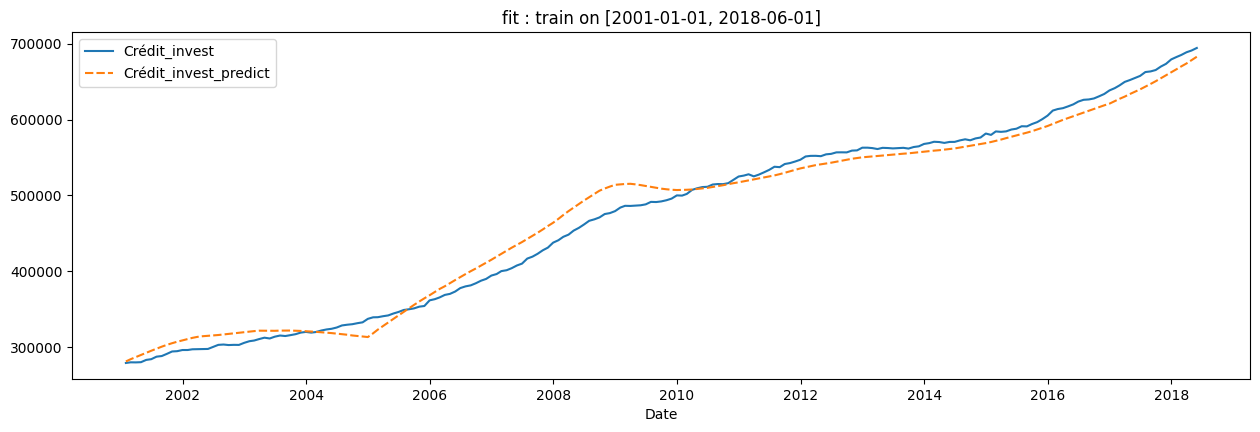

In [78]:
predict_new_prods = lr.predict(df_train[drivers])
predict_new_prods = np.triu(np.ones((timesteps, timesteps))) * predict_new_prods[:, None]
predict_new_prods = predict_new_prods * np_amort_matrix

predict_outstanding = np.sum(predict_new_prods, axis=0) + stock_outstanding

df_train['Crédit_invest_predict'] = predict_outstanding

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_train.set_index("Date")[["Crédit_invest", "Crédit_invest_predict"]], ax=ax)
figure.set_title(f"fit : train on [{train_range[0]}, {train_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_train['Crédit_invest'], df_train['Crédit_invest_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

fit : MAPE of 0.34%


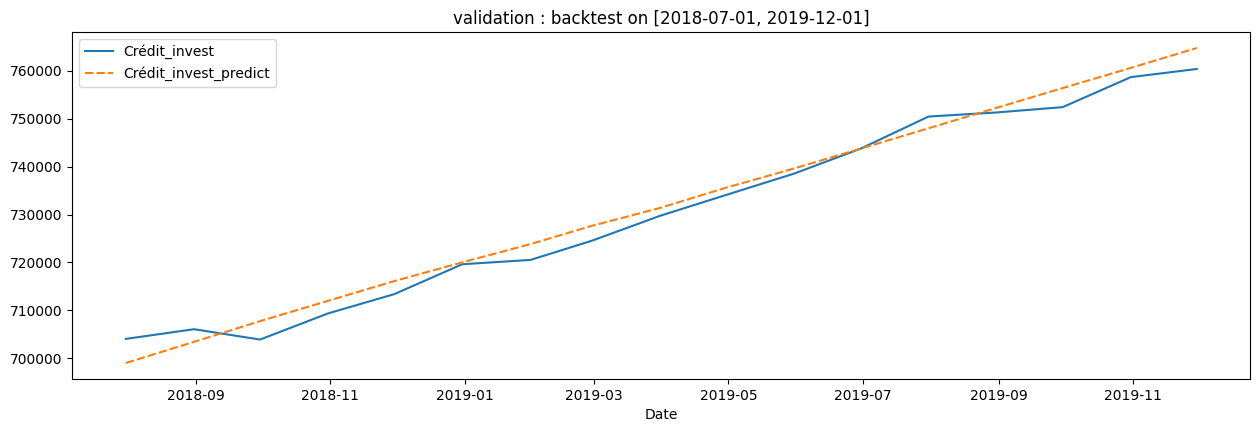

In [79]:
timesteps_total = timesteps + df_backtest.shape[0]

past_new_prods = new_prod
predict_new_prods = lr.predict(df_backtest[drivers])
total_new_prods = np.concatenate([past_new_prods, predict_new_prods])
total_new_prods = np.triu(np.ones((timesteps_total, timesteps_total))) * total_new_prods[:, None]

np_amort_matrix_init = np.array([max(1 - i / amort, 0) for i in range(timesteps_total)])
np_amort_matrix = np.array([np_amort_matrix_init])
for i in range(1, timesteps_total):
    np_amort_matrix = np.concatenate([np_amort_matrix, np.roll(np_amort_matrix_init, i)[None, :]])
np_amort_matrix = np.triu(np_amort_matrix)

total_new_prods = total_new_prods * np_amort_matrix
stock_outstanding = [max(encours_init * (1 - i / amort_stock), 0) for i in range(1, timesteps_total+1)]

total_outstanding = np.sum(total_new_prods, axis=0) + stock_outstanding

df_backtest['Crédit_invest_predict'] = total_outstanding[timesteps:]

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_backtest.set_index("Date")[["Crédit_invest", "Crédit_invest_predict"]], ax=ax)
figure.set_title(f"validation : backtest on [{backtest_range[0]}, {backtest_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_backtest['Crédit_invest'], df_backtest['Crédit_invest_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

## 2. Crédit trésorerie

In [89]:
# Data loading

df_y = df_bdf_monthly[["Date", "Crédits de trésorerie accordés aux sociétés non financières résidentes, encours"]]
df_x = pd.read_excel("Data_Scenario.xlsx")
df_x = df_x.merge(df_insee_quarterly, on='Date', how='left')
for col in df_insee_quarterly.columns:
    if col != 'Date':
        df_x[col] = df_x[col].bfill() / (1e6 * 3)

df = df_y.merge(df_x, on="Date", how="left")
df = df.sort_values('Date', ascending=True)

In [90]:
# Feature engineering

df.rename(columns={"Crédits de trésorerie accordés aux sociétés non financières résidentes, encours": "Crédit_treso"}, inplace=True)

In [91]:
train_range = ("2001-01-01", "2018-06-01")
backtest_range = ("2018-07-01", "2019-12-01")

df_train = df[(df['Date']>=train_range[0]) & (df['Date']<=train_range[1])]
display(df_train.head())

df_backtest = df[(df['Date']>=backtest_range[0]) & (df['Date']<=backtest_range[1])]

,Date,Crédit_treso,Unnamed: 0,OAT_10Y,GDP_courant,GDP_constant,Euribor_3M,CPI,Inflation,CAC40,...,Aides à l'investissement reçues par les sociétés non financières - Valeur aux prix courants - Série CVS,FBCF des ménages - Total - Valeur aux prix courants - Série CVS-CJO,Revenus de la propriété attribués aux assurés reçus par les ISBLSM - Valeur aux prix courants - Série CVS,Dépenses de consommation des ménages - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO,Produit intérieur brut total - Valeur aux prix courants - Série CVS-CJO,Formation brute de capital fixe des ISBLSM - Valeur aux prix courants - Série CVS-CJO,Autres transferts en capital reçus par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS,Intérêts versés par les ISBLSM - Valeur aux prix courants - Série CVS,Autres transferts en capital à payer par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS,Indemnités d'assurance-dommage reçues par les ISBLSM - Valeur aux prix courants - Série CVS
270,2001-01-31,170663.0,12.0,4.947,126575.419753,154582.851852,4.77438,78.5,1.21,5827.89,...,323.0,6121.666667,84.000000,78600.666667,126844.666667,210.666667,367.666667,12.666667,-132.333333,3.666667
269,2001-02-28,171724.0,13.0,4.939,126939.716049,154773.629630,4.75579,78.7,1.36,5634.29,...,323.0,6121.666667,84.000000,78600.666667,126844.666667,210.666667,367.666667,12.666667,-132.333333,3.666667
268,2001-03-31,174580.0,14.0,4.837,127276.864198,154902.518519,4.70863,79.1,1.34,5200.62,...,323.0,6121.666667,84.000000,78600.666667,126844.666667,210.666667,367.666667,12.666667,-132.333333,3.666667
267,2001-04-30,184447.0,15.0,5.014,127550.222222,154854.456790,4.68770,79.5,1.83,5346.71,...,319.0,6100.000000,84.333333,79187.333333,127735.333333,212.333333,318.666667,15.000000,-116.666667,3.666667
266,2001-05-31,183041.0,16.0,5.212,127860.555556,154945.864198,4.64386,80.0,2.26,5558.87,...,319.0,6100.000000,84.333333,79187.333333,127735.333333,212.333333,318.666667,15.000000,-116.666667,3.666667


In [93]:
amort_stock = 12 * 4
amort = 12 * 7

drivers = ["Investissement des entreprises non financières - Total - Valeur aux prix courants - Série CVS-CJO", 'OAT_10Y']

lr = LinearRegression().fit(df_train[drivers], df_train["Crédit_treso"])

from joblib import dump, load
dump(lr, 'models/_new/credit_tresorerie.joblib') 

['models/_new/credit_tresorerie.joblib']

fit : MAPE of 6.19%


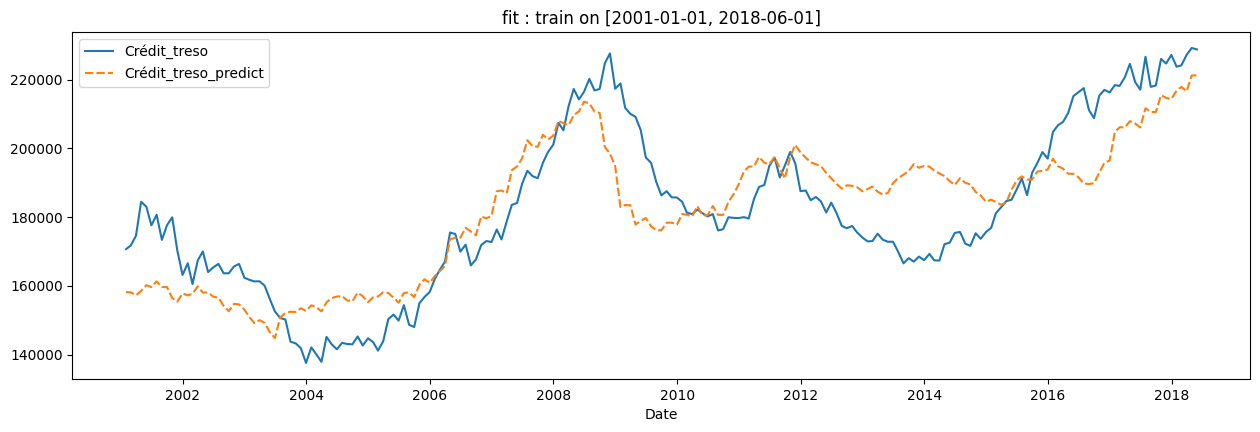

In [94]:
df_train['Crédit_treso_predict'] = lr.predict(df_train[drivers])

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_train.set_index("Date")[["Crédit_treso", "Crédit_treso_predict"]], ax=ax)
figure.set_title(f"fit : train on [{train_range[0]}, {train_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_train['Crédit_treso'], df_train['Crédit_treso_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

fit : MAPE of 6.2%


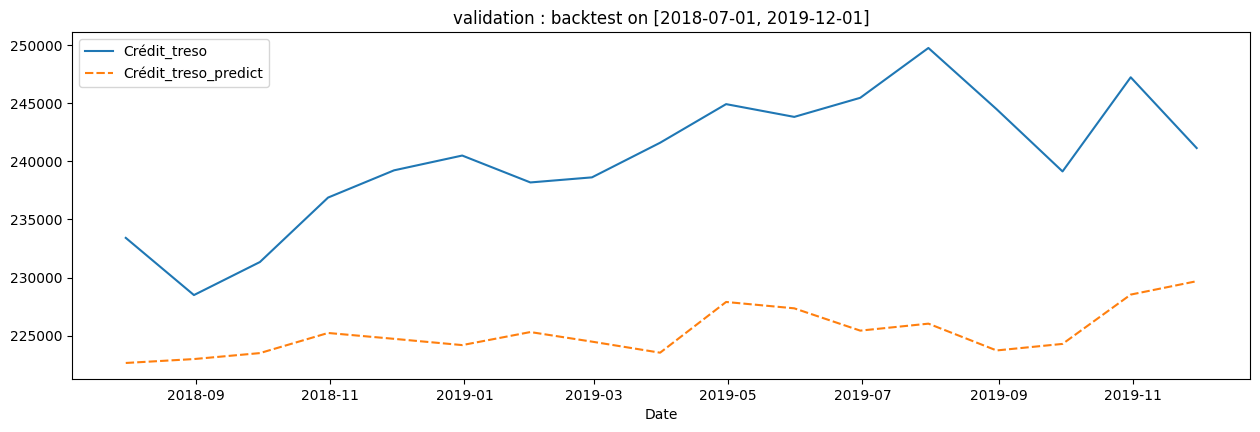

In [95]:
df_backtest['Crédit_treso_predict'] = lr.predict(df_backtest[drivers])

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_backtest.set_index("Date")[["Crédit_treso", "Crédit_treso_predict"]], ax=ax)
figure.set_title(f"validation : backtest on [{backtest_range[0]}, {backtest_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_backtest['Crédit_treso'], df_backtest['Crédit_treso_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

In [4]:
# Data prep

train_range = ("2001-01-01", "2018-06-01")
backtest_range = ("2018-07-01", "2019-12-01")

df_train = df[(df['Date']>=train_range[0]) & (df['Date']<=train_range[1])]
display(df_train.head())

df_backtest = df[(df['Date']>=backtest_range[0]) & (df['Date']<=backtest_range[1])]

,Date,Crédit_invest,RDB,Chômage,PIB,Invest_SNF,OAT_10Y,Consommation_ménages,Epargne_ménages,Invest_ménages,...,Saving_ratio_SNF,Ménages - FBCF - Courant,OAT_10Y_minus_inflation,Crédit_invest_diff,Crédit_invest_shift_1,Crédit_invest_shift_2,Crédit_invest_shift_3,Crédit_invest_shift_4,Crédit_invest_shift_5,Crédit_invest_shift_6
6,2001-01-01,279140,76739.345679,0.076000,154467.604938,102.357927,4.947,78647.012346,-1907.666667,100.221851,...,0.221797,6072.0,3.737,937.0,278203.0,275863.0,274706.0,272864.0,270975.0,270622.0
7,2001-02-01,279997,76776.086420,0.075000,154686.345679,102.750915,4.939,78886.530864,-2110.444444,100.258826,...,0.223121,6072.0,3.579,857.0,279140.0,278203.0,275863.0,274706.0,272864.0,270975.0
8,2001-03-01,279911,76879.567901,0.074000,154845.049383,103.143903,4.837,79093.456790,-2213.888889,100.295801,...,0.224445,6072.0,3.497,-86.0,279997.0,279140.0,278203.0,275863.0,274706.0,272864.0
9,2001-04-01,280175,77022.037037,0.073667,154845.444444,103.536891,5.014,79271.790123,-2249.753086,100.332777,...,0.221467,6120.0,3.184,264.0,279911.0,279997.0,279140.0,278203.0,275863.0,274706.0
10,2001-05-01,283174,77279.814815,0.073333,154957.777778,103.929879,5.212,79410.530864,-2130.716049,100.369752,...,0.218489,6120.0,2.952,2999.0,280175.0,279911.0,279997.0,279140.0,278203.0,275863.0


# Existing model

In [5]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(df_train[['Invest_SNF', 'Profit_ratio_SNF', 'OAT_10Y_minus_inflation']], df_train['Crédit_invest_diff'])

In [182]:
lr.coef_

array([   70.92694073, 23214.83265016,    48.63256816])

In [183]:
lr.intercept_

-28418.93252098034

fit : MAPE of 1.68%


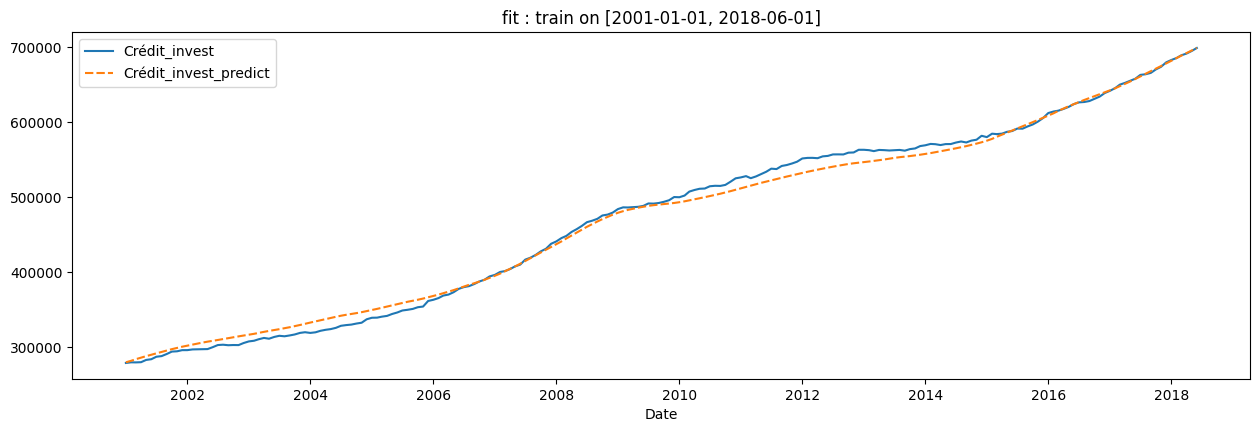

In [184]:
encours_init = df[df["Date"]<train_range[0]]['Crédit_invest'].values[-1]
df_train['Crédit_invest_predict'] = lr.predict(df_train[['Invest_SNF', 'Profit_ratio_SNF', 'OAT_10Y_minus_inflation']]).cumsum() + encours_init

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_train.set_index("Date")[["Crédit_invest", "Crédit_invest_predict"]], ax=ax)
figure.set_title(f"fit : train on [{train_range[0]}, {train_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_train['Crédit_invest'], df_train['Crédit_invest_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

fit : MAPE of 0.81%


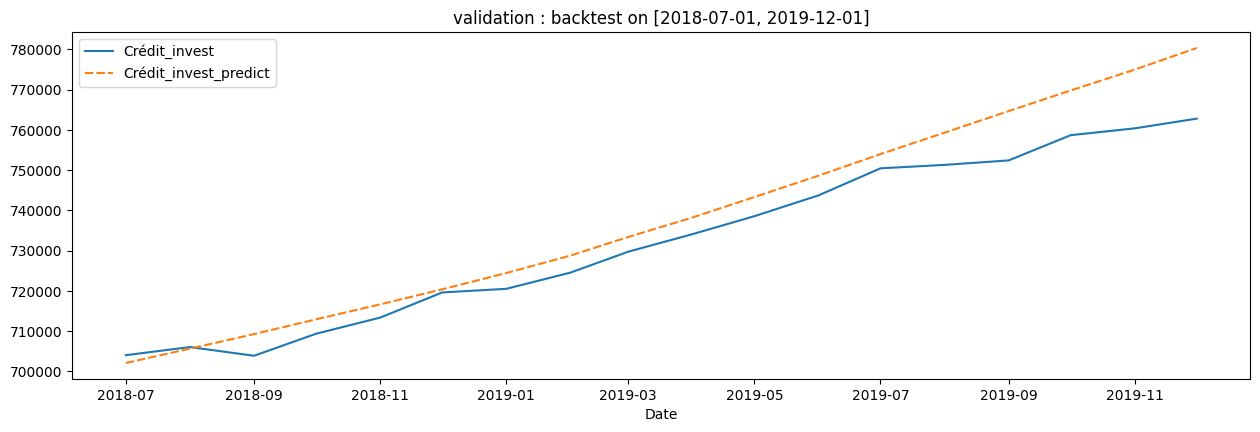

In [185]:
encours_init = df[df["Date"]<backtest_range[0]]['Crédit_invest'].values[-1]
df_backtest['Crédit_invest_predict'] = lr.predict(df_backtest[['Invest_SNF', 'Profit_ratio_SNF', 'OAT_10Y_minus_inflation']]).cumsum() + encours_init

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_backtest.set_index("Date")[["Crédit_invest", "Crédit_invest_predict"]], ax=ax)
figure.set_title(f"validation : backtest on [{backtest_range[0]}, {backtest_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_backtest['Crédit_invest'], df_backtest['Crédit_invest_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

# Autoregressive model

In [247]:
from sklearn.linear_model import LinearRegression

autoregressive_components = [f'Crédit_invest_shift_{i}' for i in range(1, 2)]
drivers = ['Invest_SNF', 'Profit_ratio_SNF', 'OAT_10Y_minus_inflation']

lr = LinearRegression().fit(df_train[drivers+autoregressive_components], df_train['Crédit_invest'])

In [248]:
lr.coef_

array([1.16437060e+02, 1.50577546e+04, 3.99964364e+01, 9.94973715e-01])

In [249]:
lr.intercept_

-23602.249669782526

fit : MAPE of 1.54%


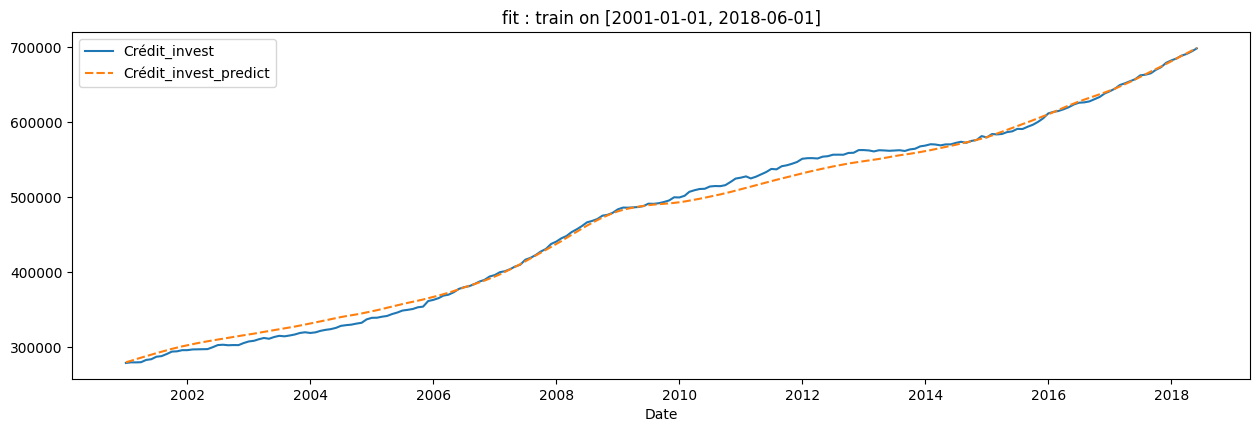

In [250]:
autoregressive = df_train[autoregressive_components].values[0, :]
predict = []
for i, row in df_train.iterrows():
    d = row[drivers].values
    p = lr.predict(np.concatenate([d, autoregressive]).reshape(1, -1))
    autoregressive = np.roll(autoregressive, shift=1)
    autoregressive[0] = p[0]
    predict.append(p[0])

df_train['Crédit_invest_predict'] = predict

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_train.set_index("Date")[["Crédit_invest", "Crédit_invest_predict"]], ax=ax)
figure.set_title(f"fit : train on [{train_range[0]}, {train_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_train['Crédit_invest'], df_train['Crédit_invest_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

fit : MAPE of 0.68%


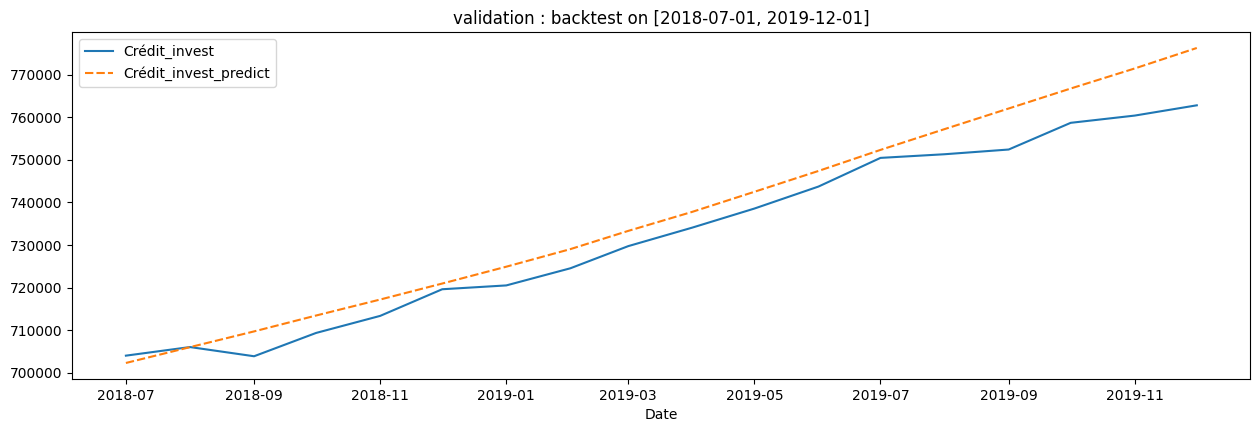

In [251]:
autoregressive = df_backtest[autoregressive_components].values[0, :]
predict = []
for i, row in df_backtest.iterrows():
    d = row[drivers].values
    p = lr.predict(np.concatenate([d, autoregressive]).reshape(1, -1))
    autoregressive = np.roll(autoregressive, shift=1)
    autoregressive[0] = p[0]
    predict.append(p[0])

df_backtest['Crédit_invest_predict'] = predict

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_backtest.set_index("Date")[["Crédit_invest", "Crédit_invest_predict"]], ax=ax)
figure.set_title(f"validation : backtest on [{backtest_range[0]}, {backtest_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_backtest['Crédit_invest'], df_backtest['Crédit_invest_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

In [252]:
''' Central projection '''

# Data prep

past_range = ("2001-01-01", "2023-05-01")
projection_range = ("2023-06-01", "2027-12-01")

df_past = df[(df['Date']>=past_range[0]) & (df['Date']<=past_range[1])]
display(df_past.head())


df_projection = pd.read_excel("credit_data.xlsx", sheet_name="drivers_forecast", skiprows=1)
df_projection = df_projection[['Date', 'Invest_SNF_central', 'Profit_ratio_SNF_central', 'OAT_10Y_central', 'Inflation_central']]
df_projection['OAT_10Y_minus_inflation'] = df_projection['OAT_10Y_central'] - df_projection['Inflation_central']
df_projection = df_projection[['Date', 'Invest_SNF_central', 'Profit_ratio_SNF_central', 'OAT_10Y_minus_inflation', 'OAT_10Y_central']]
df_projection.columns = ['Date', 'Invest_SNF', 'Profit_ratio_SNF', 'OAT_10Y_minus_inflation', 'OAT_10Y']
df_projection = df_projection[(df_projection['Date']>=projection_range[0]) & (df_projection['Date']<=projection_range[1])]

display(df_projection.head())

,Date,Crédit_invest,RDB,Chômage,PIB,Invest_SNF,OAT_10Y,Consommation_ménages,Epargne_ménages,Invest_ménages,...,Profit_ratio_SNF,Saving_ratio_SNF,OAT_10Y_minus_inflation,Crédit_invest_diff,Crédit_invest_shift_1,Crédit_invest_shift_2,Crédit_invest_shift_3,Crédit_invest_shift_4,Crédit_invest_shift_5,Crédit_invest_shift_6
6,2001-01-01,279140,76739.345679,0.076000,154467.604938,102.357927,4.947,78647.012346,-1907.666667,100.221851,...,0.983207,0.221797,3.734419,937.0,278203.0,275863.0,274706.0,272864.0,270975.0,270622.0
7,2001-02-01,279997,76776.086420,0.075000,154686.345679,102.750915,4.939,78886.530864,-2110.444444,100.258826,...,0.988285,0.223121,3.576568,857.0,279140.0,278203.0,275863.0,274706.0,272864.0,270975.0
8,2001-03-01,279911,76879.567901,0.074000,154845.049383,103.143903,4.837,79093.456790,-2213.888889,100.295801,...,0.993929,0.224445,3.493454,-86.0,279997.0,279140.0,278203.0,275863.0,274706.0,272864.0
9,2001-04-01,280175,77022.037037,0.073667,154845.444444,103.536891,5.014,79271.790123,-2249.753086,100.332777,...,0.990100,0.221467,3.180750,264.0,279911.0,279997.0,279140.0,278203.0,275863.0,274706.0
10,2001-05-01,283174,77279.814815,0.073333,154957.777778,103.929879,5.212,79410.530864,-2130.716049,100.369752,...,0.985192,0.218489,2.956361,2999.0,280175.0,279911.0,279997.0,279140.0,278203.0,275863.0


,Date,Invest_SNF,Profit_ratio_SNF,OAT_10Y_minus_inflation,OAT_10Y
23,2023-06-01,160.401085,1.094624,-3.117108,3.3
24,2023-07-01,160.156158,1.094624,-3.227117,3.3
25,2023-08-01,159.911231,1.094624,-3.209509,3.3
26,2023-09-01,152.865241,1.095603,-3.064286,3.3
27,2023-10-01,152.626610,1.095603,-2.791446,3.3


In [288]:
df_projection = pd.read_excel("credit_data.xlsx", sheet_name="drivers_forecast", skiprows=1)

df_projection[df_projection['Date'].dt.year==2026][['Date', 'Invest_SNF_central']]

,Date,Invest_SNF_central
54,2026-01-01,154.020413
55,2026-02-01,154.020413
56,2026-03-01,162.038603
57,2026-04-01,162.948060
58,2026-05-01,163.857517
59,2026-06-01,165.690480
60,2026-07-01,165.437476
61,2026-08-01,165.184472
62,2026-09-01,158.300111
63,2026-10-01,158.052996


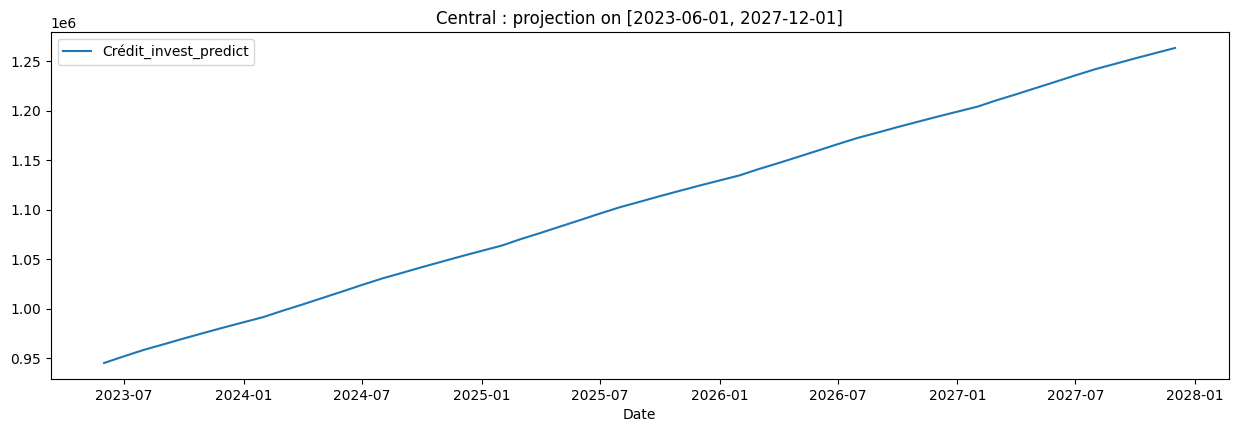

In [253]:
autoregressive = np.array([df_past['Crédit_invest'].values[-1]])
predict = []
for i, row in df_projection.iterrows():
    d = row[drivers].values
    p = lr.predict(np.concatenate([d, autoregressive]).reshape(1, -1))
    autoregressive = np.roll(autoregressive, shift=1)
    autoregressive[0] = p[0]
    predict.append(p[0])

df_projection['Crédit_invest_predict'] = predict

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_projection.set_index("Date")[["Crédit_invest_predict"]], ax=ax)
figure.set_title(f"Central : projection on [{projection_range[0]}, {projection_range[1]}]")

fig.show()

In [204]:
df_credit_invest = pd.concat([df_past[['Date', 'Crédit_invest']], df_projection[['Date', 'Crédit_invest_predict']]], axis=0)
df_credit_invest['Encours credit invest'] = df_credit_invest['Crédit_invest'].fillna(df_credit_invest['Crédit_invest_predict'])
df_credit_invest['YoY growth'] = (df_credit_invest['Encours credit invest'] - df_credit_invest['Encours credit invest'].shift(12)) / df_credit_invest['Encours credit invest'].shift(12)
df_credit_invest[[
    'Date',
    'Encours credit invest',
    'YoY growth'
]].to_excel('Autoregressive model - projection credit invest.xlsx')

PermissionError: [Errno 13] Permission denied: 'Autoregressive model - projection credit invest.xlsx'

# ARIMAX Model

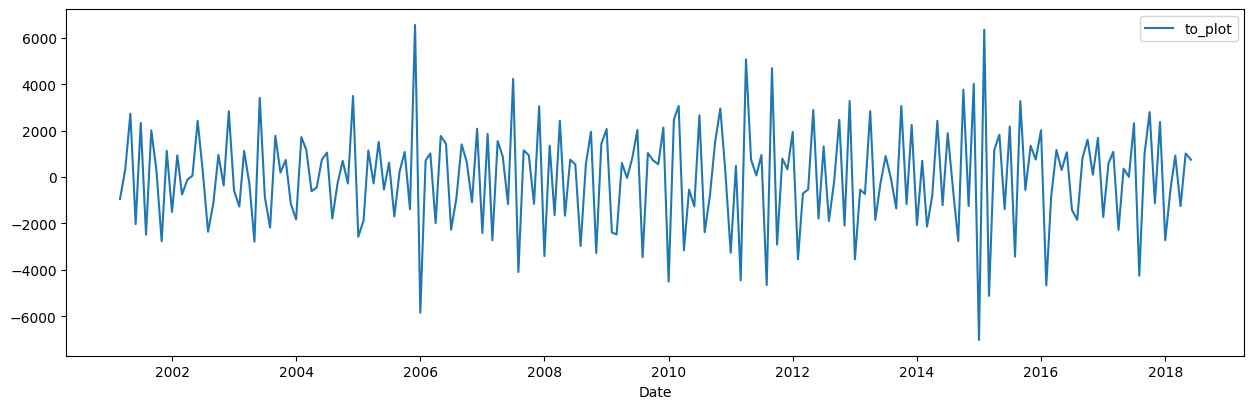

In [254]:
''' determine order for statinoarity '''

order = 2

df_plot = df_train.copy()
if order == 0:
    df_plot['to_plot'] = df_plot['Crédit_invest']
elif order == 1:
    df_plot['to_plot'] = df_plot['Crédit_invest'] - df_plot['Crédit_invest'].shift(1)
elif order == 2:
    df_plot['to_plot'] = df_plot['Crédit_invest'] - 2*df_plot['Crédit_invest'].shift(1) + df_plot['Crédit_invest'].shift(2)

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_plot.set_index("Date")[["to_plot"]], ax=ax)
fig.show()

In [256]:
import statsmodels.api as sm

drivers = ['Invest_SNF', 'Profit_ratio_SNF', 'OAT_10Y_minus_inflation']

lr = sm.tsa.arima.ARIMA(
    endog=df_train['Crédit_invest'],
    exog=df_train[drivers],
    order=(3,2,3),
    seasonal_order=(0,0,0,0)
)

lr = lr.fit()

# summary of fit model
print(lr.summary())

                               SARIMAX Results                                
Dep. Variable:          Crédit_invest   No. Observations:                  210
Model:                 ARIMA(3, 2, 3)   Log Likelihood               -1912.118
Date:                Wed, 05 Jul 2023   AIC                           3844.235
Time:                        17:46:09   BIC                           3877.611
Sample:                             0   HQIC                          3857.731
                                - 210                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Invest_SNF                710.7038    164.122      4.330      0.000     389.030    1032.378
Profit_ratio_SNF        -5.791e+04   2.46e+04     -2.356      0.018   -1.06e+05   -9729.954


fit : MAPE of 0.37%


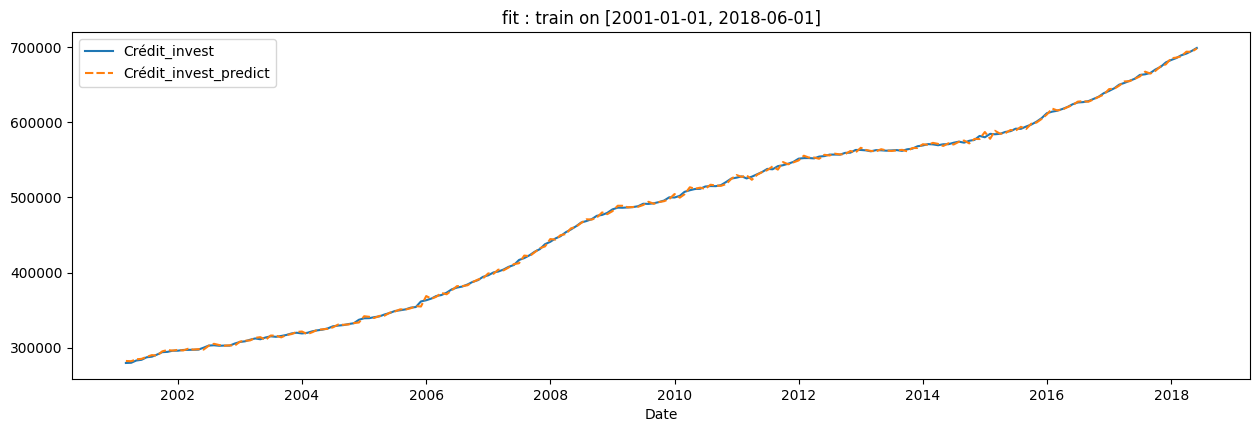

In [257]:
df_train['Crédit_invest_predict'] = lr.predict().values

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
df_plot = df_train.iloc[2: ,:]
figure = sns.lineplot(data=df_plot.set_index("Date")[["Crédit_invest", "Crédit_invest_predict"]], ax=ax)
figure.set_title(f"fit : train on [{train_range[0]}, {train_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_plot['Crédit_invest'], df_plot['Crédit_invest_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

fit : MAPE of 0.88%


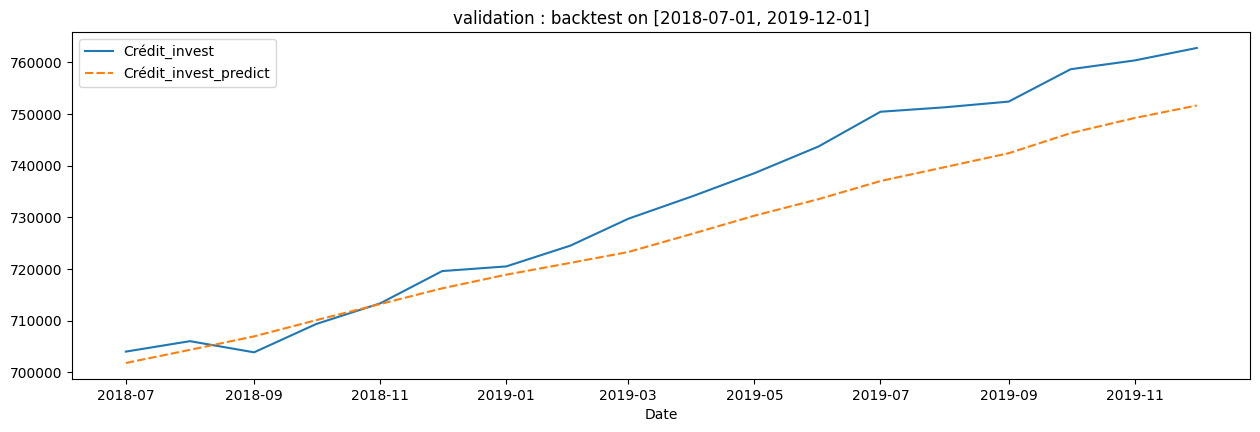

In [258]:
df_backtest['Crédit_invest_predict'] = (lr.forecast(steps=df_backtest.shape[0], exog=df_backtest[drivers])).values

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_backtest.set_index("Date")[["Crédit_invest", "Crédit_invest_predict"]], ax=ax)
figure.set_title(f"validation : backtest on [{backtest_range[0]}, {backtest_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_backtest['Crédit_invest'], df_backtest['Crédit_invest_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

In [259]:
''' Central projection '''

# Data prep

past_range = ("2001-01-01", "2023-05-01")
projection_range = ("2023-06-01", "2027-12-01")

df_past = df[(df['Date']>=past_range[0]) & (df['Date']<=past_range[1])]
display(df_past.head())


df_projection = pd.read_excel("credit_data.xlsx", sheet_name="drivers_forecast", skiprows=1)
df_projection = df_projection[['Date', 'Invest_SNF_central', 'Profit_ratio_SNF_central', 'OAT_10Y_central', 'Inflation_central']]
df_projection['OAT_10Y_minus_inflation'] = df_projection['OAT_10Y_central'] - df_projection['Inflation_central']
df_projection = df_projection[['Date', 'Invest_SNF_central', 'Profit_ratio_SNF_central', 'OAT_10Y_minus_inflation', 'OAT_10Y_central']]
df_projection.columns = ['Date', 'Invest_SNF', 'Profit_ratio_SNF', 'OAT_10Y_minus_inflation', 'OAT_10Y']

df_past = df_past.merge(df_projection.rename(columns={'Invest_SNF': 'Invest_SNF_x', 'Profit_ratio_SNF': 'Profit_ratio_SNF_x', 'OAT_10Y_minus_inflation': 'OAT_10Y_minus_inflation_x', 'OAT_10Y': 'OAT_10Y_x'}), on='Date', how='left')
df_past['Invest_SNF'] = df_past['Invest_SNF'].fillna(df_past['Invest_SNF_x'])
df_past['Profit_ratio_SNF'] = df_past['Profit_ratio_SNF'].fillna(df_past['Profit_ratio_SNF_x'])
df_past['OAT_10Y_minus_inflation'] = df_past['OAT_10Y_minus_inflation'].fillna(df_past['OAT_10Y_minus_inflation_x'])
df_past['OAT_10Y'] = df_past['OAT_10Y'].fillna(df_past['OAT_10Y_x'])

df_projection = df_projection[(df_projection['Date']>=projection_range[0]) & (df_projection['Date']<=projection_range[1])]

display(df_projection.head())

,Date,Crédit_invest,RDB,Chômage,PIB,Invest_SNF,OAT_10Y,Consommation_ménages,Epargne_ménages,Invest_ménages,...,Profit_ratio_SNF,Saving_ratio_SNF,OAT_10Y_minus_inflation,Crédit_invest_diff,Crédit_invest_shift_1,Crédit_invest_shift_2,Crédit_invest_shift_3,Crédit_invest_shift_4,Crédit_invest_shift_5,Crédit_invest_shift_6
6,2001-01-01,279140,76739.345679,0.076000,154467.604938,102.357927,4.947,78647.012346,-1907.666667,100.221851,...,0.983207,0.221797,3.734419,937.0,278203.0,275863.0,274706.0,272864.0,270975.0,270622.0
7,2001-02-01,279997,76776.086420,0.075000,154686.345679,102.750915,4.939,78886.530864,-2110.444444,100.258826,...,0.988285,0.223121,3.576568,857.0,279140.0,278203.0,275863.0,274706.0,272864.0,270975.0
8,2001-03-01,279911,76879.567901,0.074000,154845.049383,103.143903,4.837,79093.456790,-2213.888889,100.295801,...,0.993929,0.224445,3.493454,-86.0,279997.0,279140.0,278203.0,275863.0,274706.0,272864.0
9,2001-04-01,280175,77022.037037,0.073667,154845.444444,103.536891,5.014,79271.790123,-2249.753086,100.332777,...,0.990100,0.221467,3.180750,264.0,279911.0,279997.0,279140.0,278203.0,275863.0,274706.0
10,2001-05-01,283174,77279.814815,0.073333,154957.777778,103.929879,5.212,79410.530864,-2130.716049,100.369752,...,0.985192,0.218489,2.956361,2999.0,280175.0,279911.0,279997.0,279140.0,278203.0,275863.0


,Date,Invest_SNF,Profit_ratio_SNF,OAT_10Y_minus_inflation,OAT_10Y
23,2023-06-01,160.401085,1.094624,-3.117108,3.3
24,2023-07-01,160.156158,1.094624,-3.227117,3.3
25,2023-08-01,159.911231,1.094624,-3.209509,3.3
26,2023-09-01,152.865241,1.095603,-3.064286,3.3
27,2023-10-01,152.626610,1.095603,-2.791446,3.3


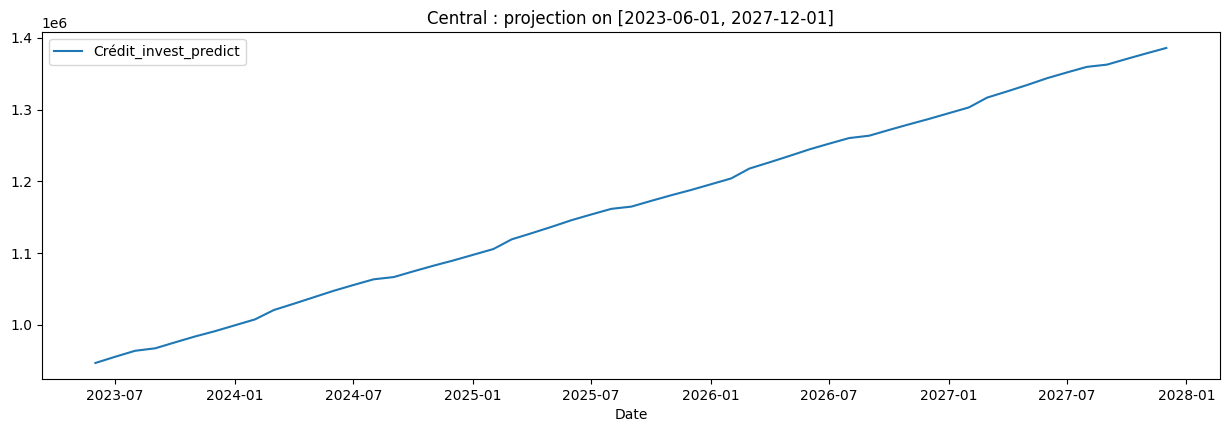

In [260]:
lr = lr.apply(df_past['Crédit_invest'].values, exog=df_past[drivers])

df_projection['Crédit_invest_predict'] = (lr.forecast(steps=df_projection.shape[0], exog=df_projection[drivers])).values

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_projection.set_index("Date")[["Crédit_invest_predict"]], ax=ax)
figure.set_title(f"Central : projection on [{projection_range[0]}, {projection_range[1]}]")

fig.show()

In [261]:
df_credit_invest = pd.concat([df_past[['Date', 'Crédit_invest']], df_projection[['Date', 'Crédit_invest_predict']]], axis=0)
df_credit_invest['Encours credit invest'] = df_credit_invest['Crédit_invest'].fillna(df_credit_invest['Crédit_invest_predict'])
df_credit_invest['YoY growth'] = (df_credit_invest['Encours credit invest'] - df_credit_invest['Encours credit invest'].shift(12)) / df_credit_invest['Encours credit invest'].shift(12)
df_credit_invest[[
    'Date',
    'Encours credit invest',
    'YoY growth'
]].to_excel('ARIMA model - projection credit invest.xlsx')

PermissionError: [Errno 13] Permission denied: 'ARIMA model - projection credit invest.xlsx'

# New Prod model

In [8]:
from sklearn.tree import DecisionTreeRegressor

amort_stock = 12 * 4
amort = 12 * 7
# drivers = ['Invest_SNF', 'Profit_ratio_SNF', 'OAT_10Y_minus_inflation']
drivers = ['Invest_SNF', 'Profit_ratio_SNF', 'OAT_10Y_minus_inflation']

timesteps = df_train.shape[0]
encours_init = df[df["Date"]<train_range[0]]['Crédit_invest'].values[-1]

stock_outstanding = [max(encours_init * (1 - i / amort_stock), 0) for i in range(1, timesteps+1)]
target_outstanding = df_train['Crédit_invest'].values

target_np = target_outstanding - stock_outstanding

np_amort_matrix_init = np.array([max(1 - i / amort, 0) for i in range(timesteps)])
np_amort_matrix = np.array([np_amort_matrix_init])
for i in range(1, timesteps):
    np_amort_matrix = np.concatenate([np_amort_matrix, np.roll(np_amort_matrix_init, i)[None, :]])
np_amort_matrix = np.triu(np_amort_matrix)

new_prod = np.linalg.solve(np_amort_matrix.T, target_np)

lr = LinearRegression().fit(df_train[drivers], new_prod)
# lr = DecisionTreeRegressor(max_depth=3).fit(df_train[drivers], new_prod)

In [7]:
from joblib import dump, load
dump(lr, '../Python package/models/credit_investissement.joblib') 

['../Python package/models/credit_investissement.joblib']

In [263]:
lr.coef_

array([   227.87986194, -15080.06882355,   -283.73246656])

In [264]:
lr.intercept_

816.384661542932

fit : MAPE of 2.17%


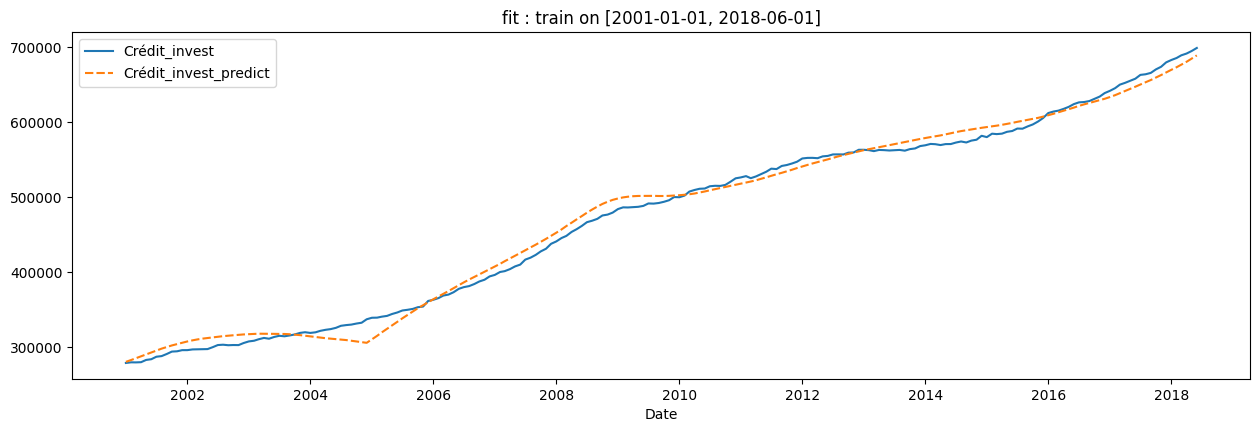

In [9]:
predict_new_prods = lr.predict(df_train[drivers])
predict_new_prods = np.triu(np.ones((timesteps, timesteps))) * predict_new_prods[:, None]
predict_new_prods = predict_new_prods * np_amort_matrix

predict_outstanding = np.sum(predict_new_prods, axis=0) + stock_outstanding

df_train['Crédit_invest_predict'] = predict_outstanding

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_train.set_index("Date")[["Crédit_invest", "Crédit_invest_predict"]], ax=ax)
figure.set_title(f"fit : train on [{train_range[0]}, {train_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_train['Crédit_invest'], df_train['Crédit_invest_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

fit : MAPE of 0.44%


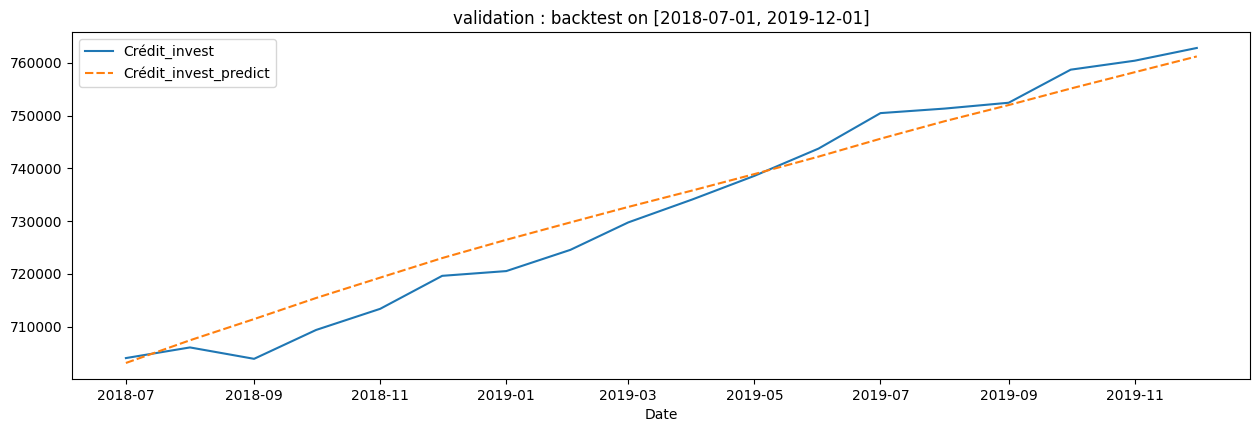

In [266]:
timesteps_total = timesteps + df_backtest.shape[0]

past_new_prods = new_prod
predict_new_prods = lr.predict(df_backtest[drivers])
total_new_prods = np.concatenate([past_new_prods, predict_new_prods])
total_new_prods = np.triu(np.ones((timesteps_total, timesteps_total))) * total_new_prods[:, None]

np_amort_matrix_init = np.array([max(1 - i / amort, 0) for i in range(timesteps_total)])
np_amort_matrix = np.array([np_amort_matrix_init])
for i in range(1, timesteps_total):
    np_amort_matrix = np.concatenate([np_amort_matrix, np.roll(np_amort_matrix_init, i)[None, :]])
np_amort_matrix = np.triu(np_amort_matrix)

total_new_prods = total_new_prods * np_amort_matrix
stock_outstanding = [max(encours_init * (1 - i / amort_stock), 0) for i in range(1, timesteps_total+1)]

total_outstanding = np.sum(total_new_prods, axis=0) + stock_outstanding

df_backtest['Crédit_invest_predict'] = total_outstanding[timesteps:]

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_backtest.set_index("Date")[["Crédit_invest", "Crédit_invest_predict"]], ax=ax)
figure.set_title(f"validation : backtest on [{backtest_range[0]}, {backtest_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_backtest['Crédit_invest'], df_backtest['Crédit_invest_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

check : MAPE of 0.0%


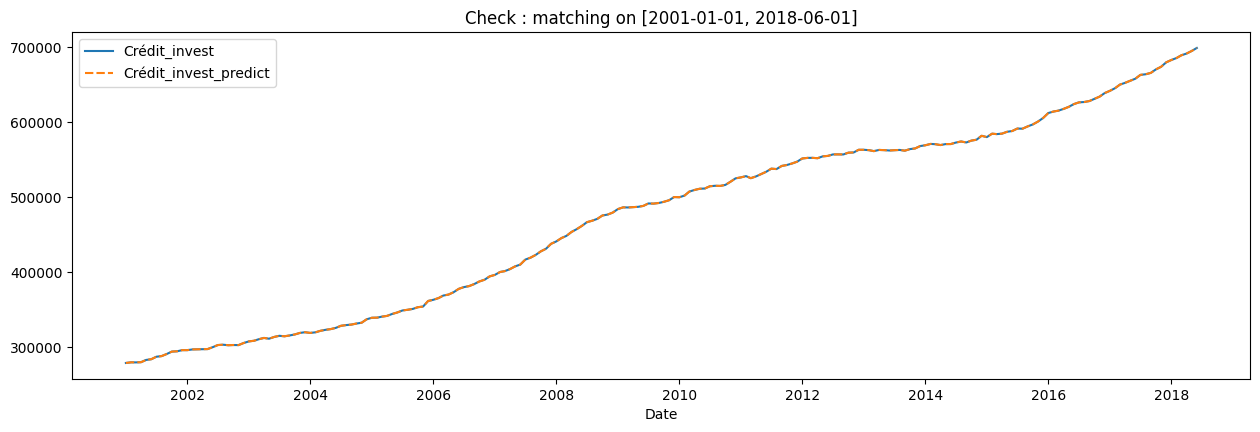

In [267]:
df_train['Crédit_invest_predict'] = total_outstanding[:timesteps]

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_train.set_index("Date")[["Crédit_invest", "Crédit_invest_predict"]], ax=ax)
figure.set_title(f"Check : matching on [{train_range[0]}, {train_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_train['Crédit_invest'], df_train['Crédit_invest_predict'])
print(f"check : MAPE of {round(100*mape, 2)}%")
fig.show()

In [268]:
''' Central projection '''

# Data prep

past_range = ("2001-01-01", "2023-05-01")
projection_range = ("2023-06-01", "2027-12-01")

df_past = df[(df['Date']>=past_range[0]) & (df['Date']<=past_range[1])]
display(df_past.head())


df_projection = pd.read_excel("credit_data.xlsx", sheet_name="drivers_forecast", skiprows=1)
df_projection = df_projection[['Date', 'Invest_SNF_central', 'Profit_ratio_SNF_central', 'OAT_10Y_central', 'Inflation_central']]
df_projection['OAT_10Y_minus_inflation'] = df_projection['OAT_10Y_central'] - df_projection['Inflation_central']
df_projection = df_projection[['Date', 'Invest_SNF_central', 'Profit_ratio_SNF_central', 'OAT_10Y_minus_inflation', 'OAT_10Y_central']]
df_projection.columns = ['Date', 'Invest_SNF', 'Profit_ratio_SNF', 'OAT_10Y_minus_inflation', 'OAT_10Y']
df_projection = df_projection[(df_projection['Date']>=projection_range[0]) & (df_projection['Date']<=projection_range[1])]

display(df_projection.head())

,Date,Crédit_invest,RDB,Chômage,PIB,Invest_SNF,OAT_10Y,Consommation_ménages,Epargne_ménages,Invest_ménages,...,Profit_ratio_SNF,Saving_ratio_SNF,OAT_10Y_minus_inflation,Crédit_invest_diff,Crédit_invest_shift_1,Crédit_invest_shift_2,Crédit_invest_shift_3,Crédit_invest_shift_4,Crédit_invest_shift_5,Crédit_invest_shift_6
6,2001-01-01,279140,76739.345679,0.076000,154467.604938,102.357927,4.947,78647.012346,-1907.666667,100.221851,...,0.983207,0.221797,3.734419,937.0,278203.0,275863.0,274706.0,272864.0,270975.0,270622.0
7,2001-02-01,279997,76776.086420,0.075000,154686.345679,102.750915,4.939,78886.530864,-2110.444444,100.258826,...,0.988285,0.223121,3.576568,857.0,279140.0,278203.0,275863.0,274706.0,272864.0,270975.0
8,2001-03-01,279911,76879.567901,0.074000,154845.049383,103.143903,4.837,79093.456790,-2213.888889,100.295801,...,0.993929,0.224445,3.493454,-86.0,279997.0,279140.0,278203.0,275863.0,274706.0,272864.0
9,2001-04-01,280175,77022.037037,0.073667,154845.444444,103.536891,5.014,79271.790123,-2249.753086,100.332777,...,0.990100,0.221467,3.180750,264.0,279911.0,279997.0,279140.0,278203.0,275863.0,274706.0
10,2001-05-01,283174,77279.814815,0.073333,154957.777778,103.929879,5.212,79410.530864,-2130.716049,100.369752,...,0.985192,0.218489,2.956361,2999.0,280175.0,279911.0,279997.0,279140.0,278203.0,275863.0


,Date,Invest_SNF,Profit_ratio_SNF,OAT_10Y_minus_inflation,OAT_10Y
23,2023-06-01,160.401085,1.094624,-3.117108,3.3
24,2023-07-01,160.156158,1.094624,-3.227117,3.3
25,2023-08-01,159.911231,1.094624,-3.209509,3.3
26,2023-09-01,152.865241,1.095603,-3.064286,3.3
27,2023-10-01,152.626610,1.095603,-2.791446,3.3


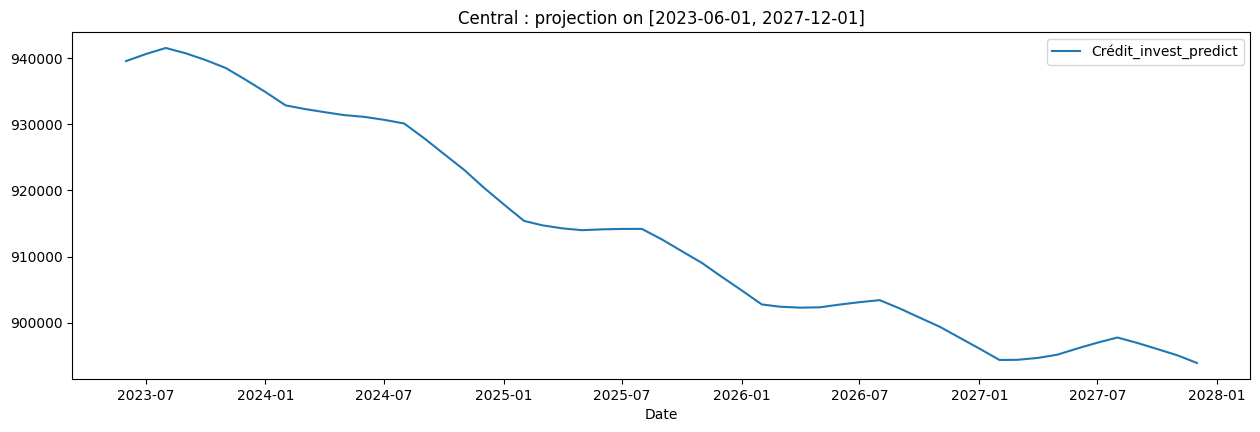

In [269]:
timesteps = df_past.shape[0]
encours_init = df[df["Date"]<past_range[0]]['Crédit_invest'].values[-1]

stock_outstanding = [max(encours_init * (1 - i / amort_stock), 0) for i in range(1, timesteps+1)]
target_outstanding = df_past['Crédit_invest'].values

target_np = target_outstanding - stock_outstanding

np_amort_matrix_init = np.array([max(1 - i / amort, 0) for i in range(timesteps)])
np_amort_matrix = np.array([np_amort_matrix_init])
for i in range(1, timesteps):
    np_amort_matrix = np.concatenate([np_amort_matrix, np.roll(np_amort_matrix_init, i)[None, :]])
np_amort_matrix = np.triu(np_amort_matrix)

new_prod = np.linalg.solve(np_amort_matrix.T, target_np)

timesteps_total = timesteps + df_projection.shape[0]

past_new_prods = new_prod
predict_new_prods = lr.predict(df_projection[drivers])
total_new_prods = np.concatenate([past_new_prods, predict_new_prods])
total_new_prods = np.triu(np.ones((timesteps_total, timesteps_total))) * total_new_prods[:, None]

np_amort_matrix_init = np.array([max(1 - i / amort, 0) for i in range(timesteps_total)])
np_amort_matrix = np.array([np_amort_matrix_init])
for i in range(1, timesteps_total):
    np_amort_matrix = np.concatenate([np_amort_matrix, np.roll(np_amort_matrix_init, i)[None, :]])
np_amort_matrix = np.triu(np_amort_matrix)

total_new_prods = total_new_prods * np_amort_matrix
stock_outstanding = [max(encours_init * (1 - i / amort_stock), 0) for i in range(1, timesteps_total+1)]

total_outstanding = np.sum(total_new_prods, axis=0) + stock_outstanding

df_projection['Crédit_invest_predict'] = total_outstanding[timesteps:]

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_projection.set_index("Date")[["Crédit_invest_predict"]], ax=ax)
figure.set_title(f"Central : projection on [{projection_range[0]}, {projection_range[1]}]")

fig.show()


In [129]:
df_credit_invest = pd.concat([df_past[['Date', 'Crédit_invest']], df_projection[['Date', 'Crédit_invest_predict']]], axis=0)
df_credit_invest['Encours credit invest'] = df_credit_invest['Crédit_invest'].fillna(df_credit_invest['Crédit_invest_predict'])
df_credit_invest['YoY growth'] = (df_credit_invest['Encours credit invest'] - df_credit_invest['Encours credit invest'].shift(12)) / df_credit_invest['Encours credit invest'].shift(12)
df_credit_invest[[
    'Date',
    'Encours credit invest',
    'YoY growth'
]].to_excel('NP model - projection credit invest.xlsx')

# Thomas model

fit : MAPE of 1.08%


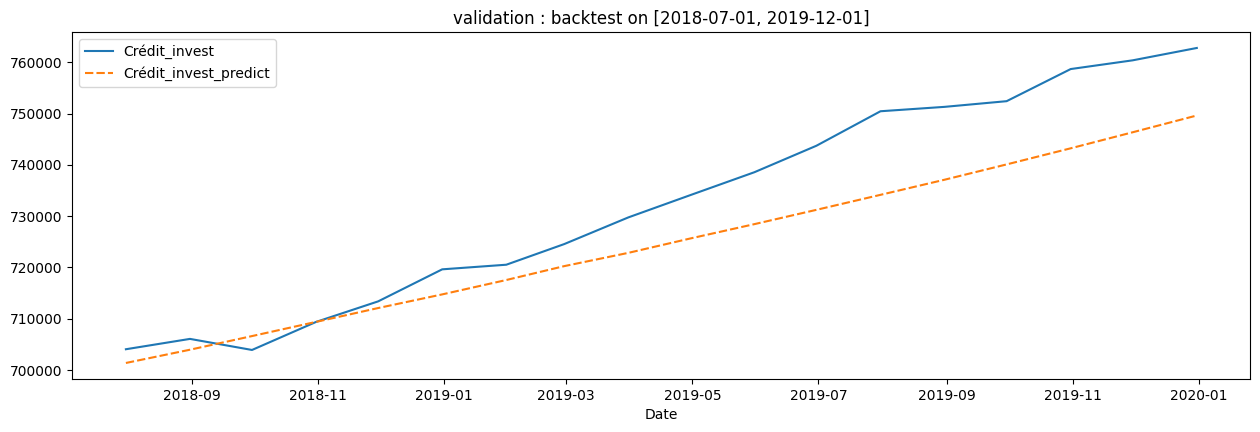

In [271]:
df_thomas_model = pd.read_excel("credit_data.xlsx", sheet_name="Thomas Genouel modèle")

df_backtest = df_thomas_model

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_backtest.set_index("Date")[["Crédit_invest", "Crédit_invest_predict"]], ax=ax)
figure.set_title(f"validation : backtest on [{backtest_range[0]}, {backtest_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_backtest['Crédit_invest'], df_backtest['Crédit_invest_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")

In [368]:
# control continue = 40% bac

coeff_total_epreuves = 5+5+8+10+16+16

In [369]:
coeff_maths = 0.6 * 16 / (coeff_total_epreuves)

In [371]:
(15-6) * coeff_maths

1.44

In [370]:
coeff_maths

0.16

In [ ]:
np.linalg.solve()

In [260]:
np_amort_matrix

array([[1.        , 0.97916667, 0.95833333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.97916667, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.97916667,
        0.95833333],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.97916667],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [259]:
new_prod.shape

(210,)

In [262]:
new_prod

array([ 6732.89583333,  6793.16449653,  5991.68875687,  6466.51560597,
        9336.2346811 ,  7504.73957029,  9997.08831134,  7724.36098449,
        9904.28517166, 10424.62444607,  7875.80412203,  9168.88337458,
        7855.90177821,  8955.56639859,  8394.14069856,  8451.01862978,
        8687.0815179 , 11289.06238286, 11756.2511825 ,  9645.17308214,
        8712.11418802,  9850.61656693,  9691.83774541, 12731.75103177,
       12409.99584494, 11397.53742504, 12762.98612139, 12751.88166559,
       10234.54586696, 13863.76557252, 13303.59402195, 11403.75223074,
       13422.33040221, 13895.96228559, 14926.46149987, 14083.42944779,
       12549.83422795, 14535.2891077 , 16012.10763078, 15734.69320642,
       15614.49931488, 16698.80138394, 18100.69307944, 16690.79085193,
       16769.51566135, 17817.88057096, 17914.08641619, 21785.29654986,
       13871.26106131, 12146.97700356, 13406.51476412, 13287.99030594,
       14952.10436219, 14531.10164721, 15299.48419048, 13714.9507713 ,
      

In [234]:
np_amort_matrix

array([1.        , 0.97916667, 0.95833333, 0.9375    , 0.91666667,
       0.89583333, 0.875     , 0.85416667, 0.83333333, 0.8125    ,
       0.79166667, 0.77083333, 0.75      , 0.72916667, 0.70833333,
       0.6875    , 0.66666667, 0.64583333, 0.625     , 0.60416667,
       0.58333333, 0.5625    , 0.54166667, 0.52083333, 0.5       ,
       0.47916667, 0.45833333, 0.4375    , 0.41666667, 0.39583333,
       0.375     , 0.35416667, 0.33333333, 0.3125    , 0.29166667,
       0.27083333, 0.25      , 0.22916667, 0.20833333, 0.1875    ,
       0.16666667, 0.14583333, 0.125     , 0.10416667, 0.08333333,
       0.0625    , 0.04166667, 0.02083333, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     